## RDPG-Based Simulation – Synthetic Graphs for Anomaly Detection Pipeline Development

In [1]:
# === Standard Library ===
import random                                             
import time                                              
from itertools import product                            

# === Numerical Computation & Statistics ===
import numpy as np                                       
import pandas as pd                                      
from numpy.linalg import norm, svd                       
from scipy import sparse as sp                           
from scipy.linalg import orthogonal_procrustes            
from scipy.optimize import linear_sum_assignment          
from scipy.spatial import distance                       
from scipy.special import softmax                         
from scipy.sparse.linalg import svds                      
from scipy.stats import ks_1samp, ks_2samp, pearsonr, uniform

# === Visualisation ===
import matplotlib.pyplot as plt                          
import seaborn as sns                                    
from matplotlib.colors import ListedColormap             
from matplotlib.lines import Line2D                      
from matplotlib.patches import Patch                     
import matplotlib.gridspec as gridspec
from IPython.display import display

# === Graph & Network Analysis ===
import networkx as nx                                    

# === Machine Learning & Embedding ===
from sklearn.cluster import KMeans                      
from sklearn.decomposition import PCA, TruncatedSVD      
from sklearn.manifold import TSNE                        
from sklearn.metrics import (
    pairwise_distances,
    pairwise_distances_argmin_min,
    precision_score,
    recall_score,
    roc_auc_score,
    silhouette_score
)
from sklearn.mixture import GaussianMixture             
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize

# === Probabilistic Programming (for MMSBM) ===
import pymc as pm                                        
import pytensor.tensor as pt                            

# === Tabular Formatting ===
from tabulate import tabulate                           

In [2]:
# Seed for reproducability
np.random.seed(42)
random.seed(42)

### <u>RDPG Graph Simulation</u>

We simulate a **Random Dot Product Graph (RDPG)** with injected anomalies and visualise the distribution of pairwise edge probabilities.

---

#### **Parameters**
- `n_nodes = 10,000`: Number of normal (non-anomalous) nodes  
- `d = 5`: Latent dimension of the embedding space  
- `anomaly_rate = 2%`: Proportion of anomalous nodes split equally between pure and mixed. Pure/structural are used interchangeably.  
- Community sizes:  
  - **X1**: 60%  
  - **X2**: 20%  
  - **X3**: 20%

---

#### **Step 1: Latent Structure**
- Generate three distinct clusters (`X1`, `X2`, `X3`) from 2D Gaussian distributions centred at:
  - X1: (0.1, 0.8)
  - X2: (0.5, 0.6)
  - X3: (0.9, 0.2)  
  with a standard deviation of 0.1 in each coordinate.  
- Extend each point to 5D by appending small Gaussian noise ($\sigma = 0.05$) in the extra dimensions.  
- Project all vectors into the **unit ball** by elementwise absolute value and scaling:  
  $$
  \mathbf{x}_i \leftarrow \frac{|\mathbf{x}_i|}{1 + \|\mathbf{x}_i\|_2}
  $$

---

#### **Step 2: Inject Anomalies**
- **Pure anomalies**: Random 5D Gaussian vectors (mean = 0.5, standard deviation = 0.3), projected into the unit ball. These are unrelated to the original clusters.  
- **Mixed anomalies**:  
  - Obtain three cluster centres from a Gaussian Mixture Model (GMM) fit to the base latent positions.  
  - Sample convex combinations of these centres from a Dirichlet(1,1,1) distribution.  
  - Add isotropic Gaussian noise ($\sigma = 0.05$).  
  - Project into the unit ball using the same transformation as above.

---

#### **Step 3: Degree Heterogeneity and Normalisation**
- Assign each node a scaling factor sampled uniformly from \([0.1, 0.5]\) to simulate heterogeneous node degrees.  
- Scale latent positions (element-wise per row):  
  $$
  \mathbf{x}_i \leftarrow s_i \cdot \mathbf{x}_i
  $$  
- Add sparse noise to 1% of coordinates.  
- Normalise all latent positions into the unit ball.

---

#### **Step 4–6: Graph Generation**
- Compute the edge probability matrix:  
  $$
  P = XX^\top
  $$  
- Sample each upper-triangular entry of \(P\) as a Bernoulli random variable.  
- Reflect to form a symmetric adjacency matrix \(A\) (undirected graph).  
- Convert \(A\) into a NetworkX graph \(G\).

---

#### **Step 7: Node Labelling**
- `0`: Normal node (from X1, X2, or X3)  
- `1`: Structural (pure) anomaly  
- `2`: Mixed-membership anomaly  
- Assign categorical colours for visualisation (e.g., blue, red, orange).

---

#### **Results**
- Graph contains `10,200` nodes (including `200` anomalies).  
- Output includes:
  - Mean edge probability $\bar{P}_{ij}$  
  - Graph density from \(A\)  
  - Histogram of all upper-triangular edge probabilities from \(P\)


Graph created with 10200 nodes:
  - 10000 normal, 100 structural anomalies, 100 mixed anomalies
  - Latent dimension: d = 5
  - Overall anomaly rate: 2.0%
  - Actual graph density: 0.0107
  - Mean edge probability P_offdiag: 0.0107


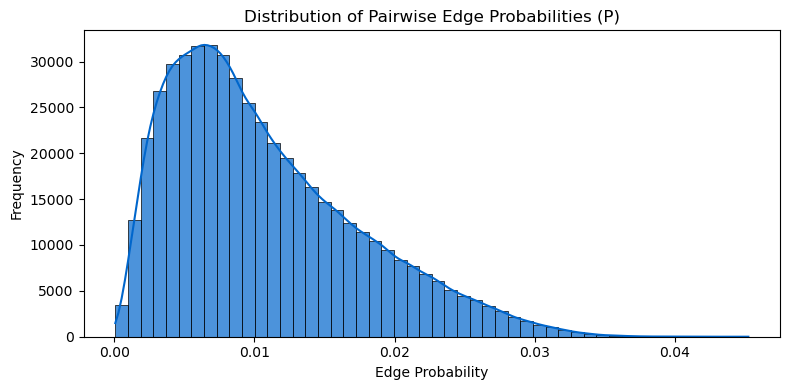

In [3]:
# ------------------------
# Reproducibility
# ------------------------
SEED = 42
random.seed(SEED)
rng = np.random.default_rng(SEED)  

# ------------------------
# RDPG Graph Simulation 
# ------------------------
# Parameters
n_nodes = 10000
d = 5
anomaly_rate = 0.02
n_total_anomalies   = int(n_nodes * anomaly_rate)
n_pure_anomalies    = n_total_anomalies // 2
n_mixed_anomalies   = n_total_anomalies // 2
X1_prop, X2_prop, X3_prop = 0.6, 0.2, 0.2
X1_count = int(n_nodes * X1_prop)
X2_count = int(n_nodes * X2_prop)
X3_count = n_nodes - X1_count - X2_count

# --- Step 1: Latent structure (well inside unit ball)
X1 = rng.normal(loc=[0.1, 0.8], scale=0.1, size=(X1_count, 2))
X2 = rng.normal(loc=[0.5, 0.6], scale=0.1, size=(X2_count, 2))
X3 = rng.normal(loc=[0.9, 0.2], scale=0.1, size=(X3_count, 2))
X_base_2d = np.vstack([X1, X2, X3])

# --- Extend to d=5 with small noise
Z_extra = rng.normal(scale=0.05, size=(X_base_2d.shape[0], d - 2))
X_base = np.hstack([X_base_2d, Z_extra])
X_base = np.abs(X_base) / (1 + np.linalg.norm(X_base, axis=1, keepdims=True))

# --- Step 2a: Pure anomalies inside unit ball
pure_anomalies = []
for _ in range(n_pure_anomalies):
    anom = rng.normal(loc=0.5, scale=0.3, size=d)
    anom = np.abs(anom) / (1 + np.linalg.norm(anom))
    pure_anomalies.append(anom)
pure_anomalies = np.vstack(pure_anomalies)

# --- Step 2b: Mixed-membership anomalies
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=SEED)
gmm.fit(X_base)

def create_mixed_membership_anomalies(gmm_model, n_anomalies=25, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    centres = gmm_model.means_
    mixed_anomalies = []
    for _ in range(n_anomalies):
        weights = rng.dirichlet([1, 1, 1])
        mix = np.sum(weights[:, None] * centres, axis=0)
        mix += rng.normal(0, 0.05, size=mix.shape)
        mix = np.abs(mix) / (1 + np.linalg.norm(mix))
        mixed_anomalies.append(mix)
    return np.array(mixed_anomalies)

mixed_anomalies = create_mixed_membership_anomalies(gmm, n_mixed_anomalies, rng=rng)

# --- Combine
X_total = np.vstack([X_base, pure_anomalies, mixed_anomalies])

# --- Step 3: Degree heterogeneity
scaling_factors = rng.uniform(0.1, 0.5, size=(X_total.shape[0], 1))
X_scaled = X_total * scaling_factors

# --- Step 4: Sparse noise injection to latent positions (before final normalisation)
noise_mask  = (rng.random(size=X_scaled.shape) < 0.01)
gauss_noise = rng.normal(loc=0.0, scale=0.05, size=X_scaled.shape)
X_noisy = X_scaled + noise_mask * gauss_noise

# Normalise after noise injection
X_final = np.abs(X_noisy) / (1 + np.linalg.norm(X_noisy, axis=1, keepdims=True))
X_final = X_final.astype(np.float32, copy=False)

# Edge probabilities
P = (X_final @ X_final.T).astype(np.float32, copy=False)  # ~100m entries for n=10k
np.clip(P, 0.0, 1.0 - 1e-12, out=P)

# --- Step 5: Adjacency matrix
A_upper = rng.binomial(1, np.triu(P, k=1))
A = A_upper + A_upper.T
G = nx.from_numpy_array(A)

# --- Step 6: Labels
true_labels = np.zeros(X_total.shape[0], dtype=int)
true_labels[n_nodes:n_nodes + n_pure_anomalies] = 1
true_labels[n_nodes + n_pure_anomalies:] = 2
anomaly_types = ['normal'] * n_nodes + ['pure'] * n_pure_anomalies + ['mixed'] * n_mixed_anomalies

# --- Results
iu = np.triu_indices_from(P, k=1)
print(f"\nGraph created with {len(X_total)} nodes:")
print(f"  - {n_nodes} normal, {n_pure_anomalies} structural anomalies, {n_mixed_anomalies} mixed anomalies")
print(f"  - Latent dimension: d = {d}")
print(f"  - Overall anomaly rate: {(n_pure_anomalies + n_mixed_anomalies)/len(X_total)*100:.1f}%")
print(f"  - Actual graph density: {nx.density(G):.4f}")
print(f"  - Mean edge probability P_offdiag: {P[iu].mean():.4f}")

# --- Plot edge probability distribution (manageable sample)
edge_probs = P[iu]
if edge_probs.size > 500_000:
    edge_probs = rng.choice(edge_probs, size=500_000, replace=False)

plt.figure(figsize=(8, 4))
sns.histplot(edge_probs, bins=50, kde=True,
             color=(0.0, 0.4, 0.8), alpha=0.7,
             edgecolor='black', linewidth=0.5)
plt.title("Distribution of Pairwise Edge Probabilities (P)")
plt.xlabel("Edge Probability")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### <u>Visualising Latent Communities and Anomalies</u>

We generate a 2D scatterplot of the latent space, clearly marked with community structures and injected anomalies.

#### Community & Anomaly Labelling
- Each node is labelled as one of:
  - **Community A**, **B**, **C**
  - **Structural anomaly**
  - **Mixed anomaly**

#### Colour Mapping (colour-blind friendly)
- `A: blue`, `B: orange`, `C: medium grey`
- `Structural -> Magenta`, `Mixed -> teal`

#### Plot Details
- 2D projection of latent vectors (first two dimensions)
- Each point coloured by its community/anomaly label
- Nodes plotted with a slight edge stroke for contrast
- KMeans centroids matched to true community means via Hungarian assignment (minimum-cost matching), then labelled A, B, and C
- Custom legend distinguishes community vs. anomaly groups

We visualise the structural separation and anomaly placement within the latent feature space.

---

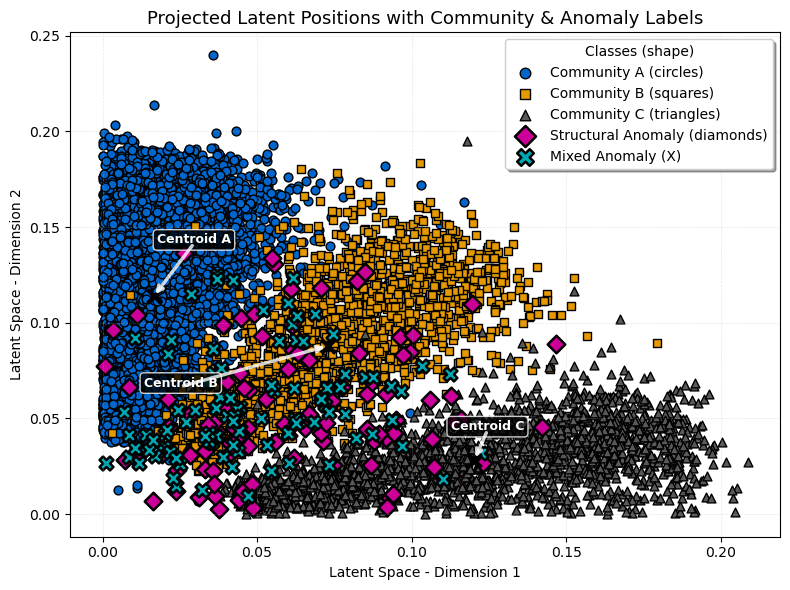

Colour-blind friendly palette:
A: RGB(0, 102, 204) - o marker
B: RGB(229, 153, 0) - s marker
C: RGB(89, 89, 89) - ^ marker
Structural: RGB(204, 0, 153) - D marker
Mixed: RGB(0, 168, 178) - X marker


In [4]:
# --- Extended community/anomaly labels ---
community_labels = (
    ['A'] * X1_count +
    ['B'] * X2_count +
    ['C'] * X3_count +
    ['Structural'] * n_pure_anomalies +
    ['Mixed'] * n_mixed_anomalies
)

# --- Colour-Blind Friendly RGB Colour Mapping ---
community_colour_map = {
    'A': (0.0, 0.4, 0.8),            # Blue 
    'B': (0.9, 0.6, 0.0),            # Orange 
    'C': (0.35, 0.35, 0.35),         # Medium grey 
    'Structural': (0.8, 0.0, 0.6),   # Magenta
    'Mixed': (0.0, 0.66, 0.70)       # Teal 
}

# --- Different marker shapes/sizes for extra distinction ---
community_marker_map = {
    'A': 'o',           # Circle
    'B': 's',           # Square
    'C': '^',           # Triangle up
    'Structural': 'D',  # Diamond
    'Mixed': 'X'        # X marker 
}

# --- Different sizes to make anomalies more visible ---
community_size_map = {
    'A': 40,            # Standard size for communities
    'B': 40,
    'C': 40,
    'Structural': 80,   # Larger for anomalies
    'Mixed': 100        # Largest for mixed anomalies
}

community_colours = [community_colour_map[label] for label in community_labels]
community_markers = [community_marker_map[label] for label in community_labels]

# --- Plot: Community and anomaly view ---
plt.figure(figsize=(8, 6))

# Use dark outline for everything; thicker for anomalies
edge = lambda lbl: 'black'
lw   = lambda lbl: 1.0 if lbl in ['A','B','C'] else 1.8

# Plot each category separately to use different markers and sizes
for label in community_colour_map.keys():
    mask = [i for i, l in enumerate(community_labels) if l == label]
    if mask:
        plt.scatter(
            X_final[mask, 0], X_final[mask, 1],
            color=community_colour_map[label],
            s=community_size_map[label],
            alpha=1.0,
            marker=community_marker_map[label],
            edgecolors=edge(label),
            linewidths=lw(label),
            label=(f'Community {label} ({ {"A":"circles","B":"squares","C":"triangles"}[label] })'
                   if label in ['A','B','C']
                   else (f'{label} Anomaly ({ {"Structural":"diamonds","Mixed":"X"}[label] })'))
        )

plt.title("Projected Latent Positions with Community & Anomaly Labels", fontsize=13)
plt.xlabel("Latent Space - Dimension 1")
plt.ylabel("Latent Space - Dimension 2")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

# --- Legend ---
plt.legend(
    loc='best', fontsize=10, frameon=True, fancybox=True, shadow=True,
    title="Classes (shape)", title_fontsize=10, markerscale=1.2, scatterpoints=1
)

# --- KMeans clustering on final (2D-projected) latent space ---
km = KMeans(n_clusters=3, random_state=42).fit(X_final[:, :2])
centroids_2d = km.cluster_centers_

# --- True post-normalisation community means for matching ---
X1_proj = X_final[:X1_count, :2]
X2_proj = X_final[X1_count:X1_count+X2_count, :2]
X3_proj = X_final[X1_count+X2_count:X1_count+X2_count+X3_count, :2]
true_means = np.array([X1_proj.mean(axis=0), X2_proj.mean(axis=0), X3_proj.mean(axis=0)])

# --- Match centroids to true means ---
dist_matrix = distance.cdist(centroids_2d, true_means)                                    # Contruct cost matrix
row_ind, col_ind = linear_sum_assignment(dist_matrix)                                     # Hungarian algorithm (minimum-cost matching)
centroid_to_mean = {cent_idx: mean_idx for cent_idx, mean_idx in zip(row_ind, col_ind)}
label_lookup     = {cent_idx: chr(65 + centroid_to_mean[cent_idx]) for cent_idx in range(3)} # Map centroids to labels A, B, C

# --- Plot labelled centroids with better contrast ---
for i, (x, y) in enumerate(centroids_2d):
    label = label_lookup[i]
    plt.text(
        x, y, f'Centroid {label}',
        fontsize=9, fontweight='bold', ha='center', color='white',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.8, edgecolor='white')
    )

# --- Annotate arrows with better visibility ---
for i in range(3):
    matched_mean = true_means[centroid_to_mean[i]]
    plt.annotate("", xy=matched_mean, xytext=centroids_2d[i],
                 arrowprops=dict(arrowstyle="->", color='white', linewidth=2.5, alpha=0.8))

# Plot true means with high contrast
plt.scatter(true_means[:, 0], true_means[:, 1], c='black', s=100, marker='x', 
           linewidths=3, label='True Means')

# --- Save as PDF ---
plt.tight_layout()
plt.savefig("latent_plot.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# --- Print colour information for verification ---
print("Colour-blind friendly palette:")
for label, color in community_colour_map.items():
    r, g, b = [int(c * 255) for c in color]
    print(f"{label}: RGB({r}, {g}, {b}) - {community_marker_map[label]} marker")

### <u>Graph Structure & Degree Statistics</u>

Compute global structural metrics and analyse node degree distributions by node type.

#### Global Graph Metrics
- **Degree**: Node-wise degree across the graph  
- **Clustering coefficient**: Average local transitivity per node  
- **Edge density**: Ratio of observed to possible edges  
- **Number of edges**: Total count of edges in the undirected graph  

#### Degree Statistics by Node Type
We report mean, minimum, maximum, standard deviation, and range for:  
- `normal` nodes  
- `structural` anomalies  
- `mixed` anomalies  

#### Visualisation: Degree Distribution
- **Histograms with KDEs** for each node type  
- Dashed vertical lines mark group means  
- Colours: Normal (blue), Structural (magenta), Mixed (teal)  
- Custom legend distinguishes groups and mean markers  

This analysis highlights how structural and mixed anomalies deviate from the normal population in connectivity patterns, a central signal in graph-based anomaly detection.  

---


=== GLOBAL GRAPH STATISTICS ===
Average degree: 109.44
Minimum degree: 13
Maximum degree: 257
Edge density: 0.0107
Average clustering coefficient: 0.0143
Total edges: 558,123

=== DEGREE STATISTICS BY NODE TYPE ===

NORMAL NODES (10000 total):
  Mean degree: 109.9
  Minimum degree: 13
  Maximum degree: 257
  Standard deviation: 42.4
  Range: 13–257

STRUCTURAL NODES (100 total):
  Mean degree: 92.2
  Minimum degree: 20
  Maximum degree: 197
  Standard deviation: 40.1
  Range: 20–197

MIXED NODES (100 total):
  Mean degree: 77.6
  Minimum degree: 20
  Maximum degree: 163
  Standard deviation: 31.9
  Range: 20–163


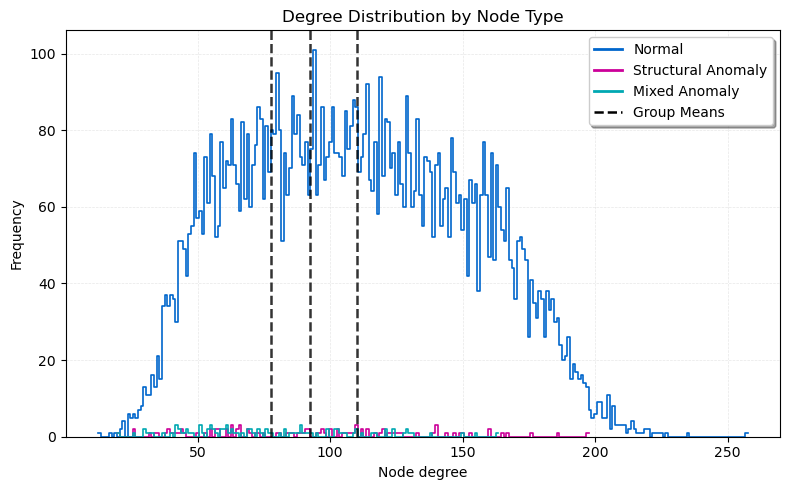


Colour-blind friendly palette used:
Normal: RGB(0, 102, 204) - #0066cc
Structural: RGB(204, 0, 153) - #cc0099
Mixed: RGB(0, 168, 178) - #00a8b2


In [5]:
# --- Degree & Structural Statistics ---
# Consistent labels
node_labels = (
    ['normal'] * n_nodes +
    ['structural'] * n_pure_anomalies +
    ['mixed'] * n_mixed_anomalies
)
assert len(G) == len(node_labels), f"Length mismatch: G has {len(G)} nodes, labels = {len(node_labels)}"

# Degrees
degrees = [d for _, d in G.degree()]
degree_series = pd.Series(degrees)

# Global metrics
avg_clustering = nx.average_clustering(G)
density = nx.density(G)
num_edges = G.number_of_edges()

print("\n=== GLOBAL GRAPH STATISTICS ===")
print(f"Average degree: {degree_series.mean():.2f}")
print(f"Minimum degree: {degree_series.min()}")
print(f"Maximum degree: {degree_series.max()}")
print(f"Edge density: {density:.4f}")
print(f"Average clustering coefficient: {avg_clustering:.4f}")
print(f"Total edges: {num_edges:,}")

# --- Degree Distribution by Class ---
labels_series = pd.Series(node_labels)
degree_df = pd.DataFrame({'degree': degree_series, 'label': labels_series})

print("\n=== DEGREE STATISTICS BY NODE TYPE ===")
for label in ['normal', 'structural', 'mixed']:
    subset = degree_df.loc[degree_df['label'] == label, 'degree']
    print(f"\n{label.upper()} NODES ({len(subset)} total):")
    print(f"  Mean degree: {subset.mean():.1f}")
    print(f"  Minimum degree: {subset.min()}")
    print(f"  Maximum degree: {subset.max()}")
    print(f"  Standard deviation: {subset.std():.1f}")
    print(f"  Range: {subset.min()}–{subset.max()}")

# --- Colour-blind friendly plotting ---
# Using consistent colours from our anomaly detection plots
colour_palette = {
    'normal': (0.0, 0.4, 0.8),        # Blue (safe for all colour vision)
    'structural': (0.8, 0.0, 0.6),    # Magenta
    'mixed': (0.0, 0.66, 0.70)        # Teal 
}

# Convert to hex for matplotlib/seaborn compatibility
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

plot_specs = [
    ('normal', rgb_to_hex(colour_palette['normal']), 'Normal'),
    ('structural', rgb_to_hex(colour_palette['structural']), 'Structural Anomaly'),
    ('mixed', rgb_to_hex(colour_palette['mixed']), 'Mixed Anomaly'),
]

# --- Plotting ---
plt.figure(figsize=(8, 5))

# Integer bins for discrete degrees (0..max)
max_deg = int(degree_series.max())
bins = np.arange(0, max_deg + 1)  # inclusive RHS

for key, colour, label in plot_specs:
    sns.histplot(
        data=degree_df[degree_df['label'] == key],
        x='degree',
        bins=bins,
        discrete=True,          # integer degrees
        element="step",         # outline for clean overlays
        fill=False,             # no filled bars
        stat="count",
        common_norm=False,
        color=colour,
        label=label,
        linewidth=1.2
    )

# Group mean markers with consistent colours
for key, _, _ in plot_specs:
    mean_deg = degree_df.loc[degree_df['label'] == key, 'degree'].mean()
    plt.axvline(mean_deg, linestyle='--', color='black', linewidth=1.8, alpha=0.8)

plt.title("Degree Distribution by Node Type", fontsize=12)
plt.xlabel("Node degree")
plt.ylabel("Frequency")

# Colour-blind friendly legend
legend_elements = [
    Line2D([0], [0], color=rgb_to_hex(colour_palette['normal']), lw=2, label='Normal'),
    Line2D([0], [0], color=rgb_to_hex(colour_palette['structural']), lw=2, label='Structural Anomaly'),
    Line2D([0], [0], color=rgb_to_hex(colour_palette['mixed']), lw=2, label='Mixed Anomaly'),
    Line2D([0], [0], linestyle='--', color='black', lw=1.8, label='Group Means')
]
plt.legend(handles=legend_elements, frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Print colour verification ---
print("\nColour-blind friendly palette used:")
for label, color in colour_palette.items():
    r, g, b = [int(c * 255) for c in color]
    print(f"{label.capitalize()}: RGB({r}, {g}, {b}) - {rgb_to_hex(color)}")

### <u>SVD Embedding with Procrustes Alignment (for RDPG Graphs)</u>

We perform dimensionality reduction and visualisation of the graph adjacency matrix `A` using Singular Value Decomposition (SVD) and Procrustes alignment to recover and interpret latent positions.

---

#### Steps

1. **Ensure Floating-Point Precision**  
   Convert the adjacency matrix `A` to floating-point format, as SVD requires numerical precision.  
   Symmetrise `A` to mitigate minor preprocessing noise.

2. **Sparsity Check**  
   Compute the proportion of zero entries in `A` to assess sparsity:  
   - If sparsity > 85%, convert `A` to CSR format and use **truncated SVD** (`scipy.sparse.linalg.svds`)  
   - Otherwise, use **full SVD** (`scipy.linalg.svd`)  

3. **Dimensionality Reduction (SVD)**  
   Extract the top `d = 5` singular vectors and singular values.  
   The unaligned latent positions are computed as:  
   $$
   X_{\text{svd}} = U \, \mathrm{diag}\!\left(\sqrt{S}\right)
   $$
   where $U \in \mathbb{R}^{n \times d}$ contains the top left singular vectors, and $S$ is the vector of top singular values.  

4. **Orthogonal Procrustes Alignment**  
   - **Full alignment:** Solve  
     $$
     \min_{R \in \mathbb{R}^{d \times d}} \| X_{\text{svd}} R - X_{\text{final}} \|_F \quad \text{s.t. } R^\top R = I
     $$  
     to align all nodes to the reference latent positions.  
   - **Restricted alignment (normals only):** Perform Procrustes using only normal nodes, then compute the alignment error as a percentage of baseline Frobenius norm.  

   This addresses rotational non-identifiability in the RDPG model.

5. **Visualisation**  
   Plot the first two coordinates of the Procrustes-aligned embedding:  
   - **Blue**: Normal nodes (circles)  
   - **Magenta**: Structural anomalies (diamonds)  
   - **Teal**: Mixed anomalies (X markers)  
   Nodes are drawn with black edges for contrast, and larger markers are used to highlight anomalies.

6. **Spectrum Analysis**  
   Report the top `d` singular values, explained variance ratios, and eigenvalue gaps to assess latent dimensionality.

---

Sparsity of A: 98.93%
Matrix is sparse (>85%), converting to sparse and using truncated SVD...


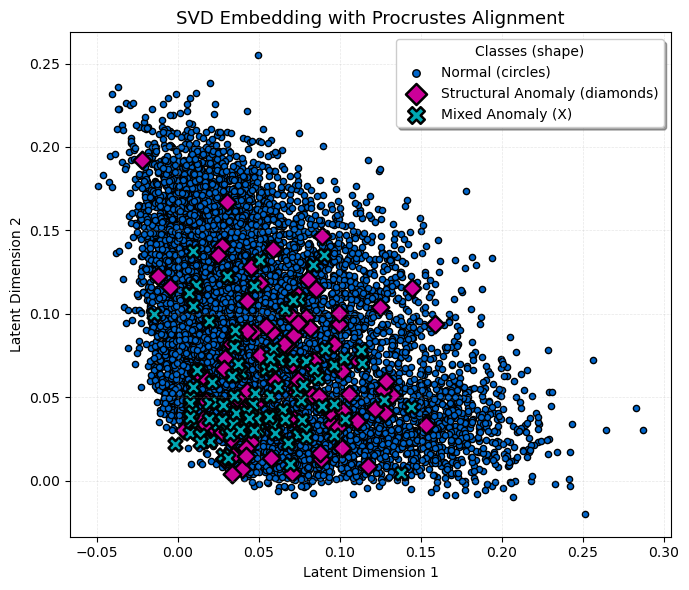

Top 5 singular values: [126.34563293  35.3618486   23.16703244  23.039104    23.01685397]
Explained variance ratio: [0.84861237 0.06647507 0.02853183 0.0282176  0.02816312]

Explained variance ratio (within top-5 spectrum): [0.849 0.066 0.029 0.028 0.028]

Restricted Procrustes alignment error: 8.6287 (68.93% of baseline norm)

Colour-blind friendly palette:
Normal: RGB(0, 102, 204) - o marker
Structural: RGB(204, 0, 153) - D marker
Mixed: RGB(0, 168, 178) - X marker

Eigenvalue gaps: [9.09837843e+01 1.21948162e+01 1.27928439e-01 2.22500295e-02]


In [6]:
# --- Ensure floating-point precision ---
A = A.astype(float)
A = 0.5 * (A + A.T)  # enforce symmetry against numeric/preprocessing noise (defensive measure)

# --- Sparsity check ---
sparsity = np.sum(A == 0) / A.size
print(f"Sparsity of A: {sparsity:.2%}")

d = 5  # embedding dimension

# --- SVD decomposition ---
if sparsity > 0.85:
    print("Matrix is sparse (>85%), converting to sparse and using truncated SVD...")
    A_sparse = sp.csr_matrix(A)
    U, S, VT = svds(A_sparse, k=d)
    U, S, VT = U[:, ::-1], S[::-1], VT[::-1, :]
else:
    print("Matrix is dense (<85% sparse), using full SVD...")
    U, S, VT = svd(A, full_matrices=False)
    U, S, VT = U[:, :d], S[:d], VT[:d, :]

# --- Construct unaligned embedding ---
X_svd = U @ np.diag(np.sqrt(S))

# --- Alignment for plotting (all nodes) ---
R_full, _ = orthogonal_procrustes(X_svd, X_final)
X_svd_aligned_full = X_svd @ R_full

# --- Colour-Blind Friendly RGB colour definitions ---
colour_normal = (0.0, 0.4, 0.8)        # Blue 
colour_structural = (0.8, 0.0, 0.6)    # Magenta
colour_mixed = (0.0, 0.66, 0.70)       # Teal

# --- Marker and size definitions for consistency ---
marker_normal = 'o'        # Circle
marker_structural = 'D'    # Diamond
marker_mixed = 'X'         # X marker

size_normal = 20           # Small for normal nodes
size_structural = 80       # Large for structural anomalies
size_mixed = 100           # Largest for mixed anomalies

# --- Edge styling function ---
edge_color = lambda is_anomaly: 'black' if is_anomaly else 'black'
edge_width = lambda is_anomaly: 1.8 if is_anomaly else 1.0

# --- Visualisation ---
fig, ax = plt.subplots(figsize=(7, 6))

# Normal nodes
ax.scatter(
    X_svd_aligned_full[true_labels == 0, 0],
    X_svd_aligned_full[true_labels == 0, 1],
    label="Normal (circles)",
    c=[colour_normal],
    s=size_normal,
    marker=marker_normal,
    edgecolors=edge_color(False),
    linewidths=edge_width(False),
    alpha=1.0
)

# Structural anomalies
ax.scatter(
    X_svd_aligned_full[true_labels == 1, 0],
    X_svd_aligned_full[true_labels == 1, 1],
    label="Structural Anomaly (diamonds)",
    c=[colour_structural],
    s=size_structural,
    marker=marker_structural,
    edgecolors=edge_color(True),
    linewidths=edge_width(True),
    alpha=1.0
)

# Mixed anomalies
ax.scatter(
    X_svd_aligned_full[true_labels == 2, 0],
    X_svd_aligned_full[true_labels == 2, 1],
    label="Mixed Anomaly (X)",
    c=[colour_mixed],
    s=size_mixed,
    marker=marker_mixed,
    edgecolors=edge_color(True),
    linewidths=edge_width(True),
    alpha=1.0
)

ax.set_title("SVD Embedding with Procrustes Alignment", fontsize=13)
ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.legend(
    loc='best', fontsize=10, frameon=True, fancybox=True, shadow=True,
    title="Classes (shape)", title_fontsize=10, markerscale=1.2, scatterpoints=1
)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.savefig("svd_embedding.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# --- Spectrum stats ---
print(f"Top {d} singular values: {S}")
print(f"Explained variance ratio: {S**2 / np.sum(S**2)}")
print(f"\nExplained variance ratio (within top-{d} spectrum): {np.round(S**2 / np.sum(S**2), 3)}")

# --- Restricted Procrustes alignment (normal nodes only) ---
normal_mask = (true_labels == 0)
R_normal, _ = orthogonal_procrustes(X_svd[normal_mask], X_final[normal_mask])
X_svd_aligned_normal = X_svd @ R_normal

alignment_error = np.linalg.norm(X_svd_aligned_normal[normal_mask] - X_final[normal_mask], 'fro')
baseline_norm = np.linalg.norm(X_final[normal_mask], 'fro')
print(f"\nRestricted Procrustes alignment error: {alignment_error:.4f} "
      f"({(alignment_error / baseline_norm)*100:.2f}% of baseline norm)")

# --- Print colour information for verification ---
print("\nColour-blind friendly palette:")
colors_info = {
    'Normal': colour_normal,
    'Structural': colour_structural,
    'Mixed': colour_mixed
}
markers_info = {
    'Normal': marker_normal,
    'Structural': marker_structural,
    'Mixed': marker_mixed
}
for label, color in colors_info.items():
    r, g, b = [int(c * 255) for c in color]
    print(f"{label}: RGB({r}, {g}, {b}) - {markers_info[label]} marker")

# Eigenvalue gap analysis for dimension selection
eigenvalue_gaps = S[:-1] - S[1:]
print(f"\nEigenvalue gaps: {eigenvalue_gaps}")

### <u>t-SNE on SVD Embedding</u>

We apply **t-distributed Stochastic Neighbour Embedding (t-SNE)** to the Procrustes-aligned SVD embedding to explore potential non-linear structure in the latent space.

---

#### Step-by-step Description

1. **Run t-SNE**
   - Input: $X_{\text{svd,aligned}}$ (5D embedding after Procrustes alignment)
   - Parameters:
     - `n_components=2`: Reduce to 2D.
     - `perplexity=50`: Controls balance between local/global structure.
     - `init='pca'`: Initialise using PCA for stability.
     - `learning_rate='auto'`: Automatically adjusts based on dataset size.
     - `random_state=42`: Ensures reproducibility.

2. **Visualise in t-SNE Space**
   - Colour coding:
     - **Blue**: Normal nodes
     - **Magenta**: Structural anomalies
     - **Teal**: Mixed-membership anomalies
   - Larger markers and black edges emphasise anomalies.

---

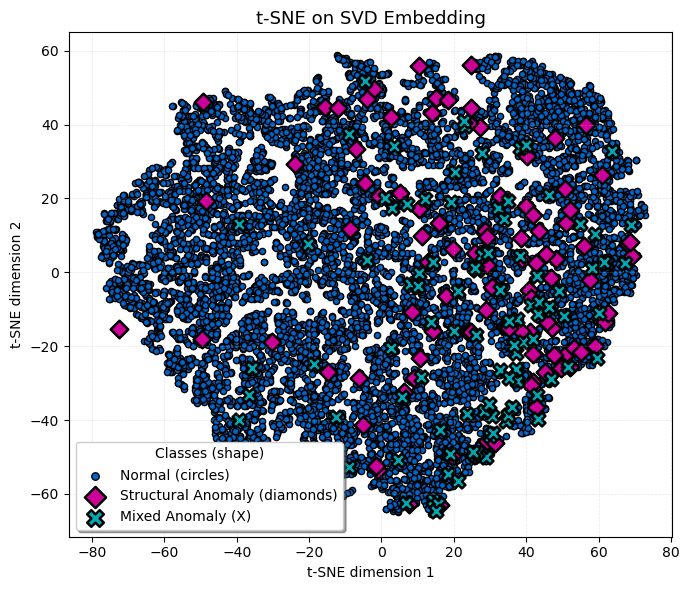

Colour-blind friendly palette:
Normal: RGB(0, 102, 204) - o marker
Structural: RGB(204, 0, 153) - D marker
Mixed: RGB(0, 168, 178) - X marker


In [7]:
# --- t-SNE on SVD embedding ---
tsne = TSNE(
    n_components=2,
    perplexity=50,
    init='pca',
    learning_rate='auto',
    random_state=42
)
X_tsne = tsne.fit_transform(X_svd_aligned_full)

# --- Colour-Blind Friendly RGB colours (matching previous plots) ---
colour_normal = (0.0, 0.4, 0.8)        # Blue (safe for all colour vision)
colour_structural = (0.8, 0.0, 0.6)    # Magenta
colour_mixed = (0.0, 0.66, 0.70)       # Teal

# --- Marker and size definitions for consistency ---
marker_normal = 'o'        # Circle
marker_structural = 'D'    # Diamond
marker_mixed = 'X'         # X marker

size_normal = 20           # Small for normal nodes
size_structural = 80       # Large for structural anomalies
size_mixed = 100           # Largest for mixed anomalies

# --- Edge styling function ---
edge_color = lambda is_anomaly: 'black' if is_anomaly else 'black'
edge_width = lambda is_anomaly: 1.8 if is_anomaly else 1.0

# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 6))

# Normal nodes
ax.scatter(
    X_tsne[true_labels == 0, 0],
    X_tsne[true_labels == 0, 1],
    label="Normal (circles)",
    c=[colour_normal],
    s=size_normal,
    marker=marker_normal,
    edgecolors=edge_color(False),
    linewidths=edge_width(False),
    alpha=1.0
)

# Structural anomalies
ax.scatter(
    X_tsne[true_labels == 1, 0],
    X_tsne[true_labels == 1, 1],
    label="Structural Anomaly (diamonds)",
    c=[colour_structural],
    s=size_structural,
    marker=marker_structural,
    edgecolors=edge_color(True),
    linewidths=edge_width(True),
    alpha=1.0
)

# Mixed anomalies
ax.scatter(
    X_tsne[true_labels == 2, 0],
    X_tsne[true_labels == 2, 1],
    label="Mixed Anomaly (X)",
    c=[colour_mixed],
    s=size_mixed,
    marker=marker_mixed,
    edgecolors=edge_color(True),
    linewidths=edge_width(True),
    alpha=1.0
)

ax.set_title("t-SNE on SVD Embedding", fontsize=13)
ax.set_xlabel("t-SNE dimension 1")
ax.set_ylabel("t-SNE dimension 2")
ax.legend(
    loc='best', fontsize=10, frameon=True, fancybox=True, shadow=True,
    title="Classes (shape)", title_fontsize=10, markerscale=1.2, scatterpoints=1
)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.savefig("tsne_on_svd_embedding.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# --- Print colour information for verification ---
print("Colour-blind friendly palette:")
colors_info = {
    'Normal': colour_normal,
    'Structural': colour_structural,
    'Mixed': colour_mixed
}
markers_info = {
    'Normal': marker_normal,
    'Structural': marker_structural,
    'Mixed': marker_mixed
}
for label, color in colors_info.items():
    r, g, b = [int(c * 255) for c in color]
    print(f"{label}: RGB({r}, {g}, {b}) - {markers_info[label]} marker")

### Plotting for Report

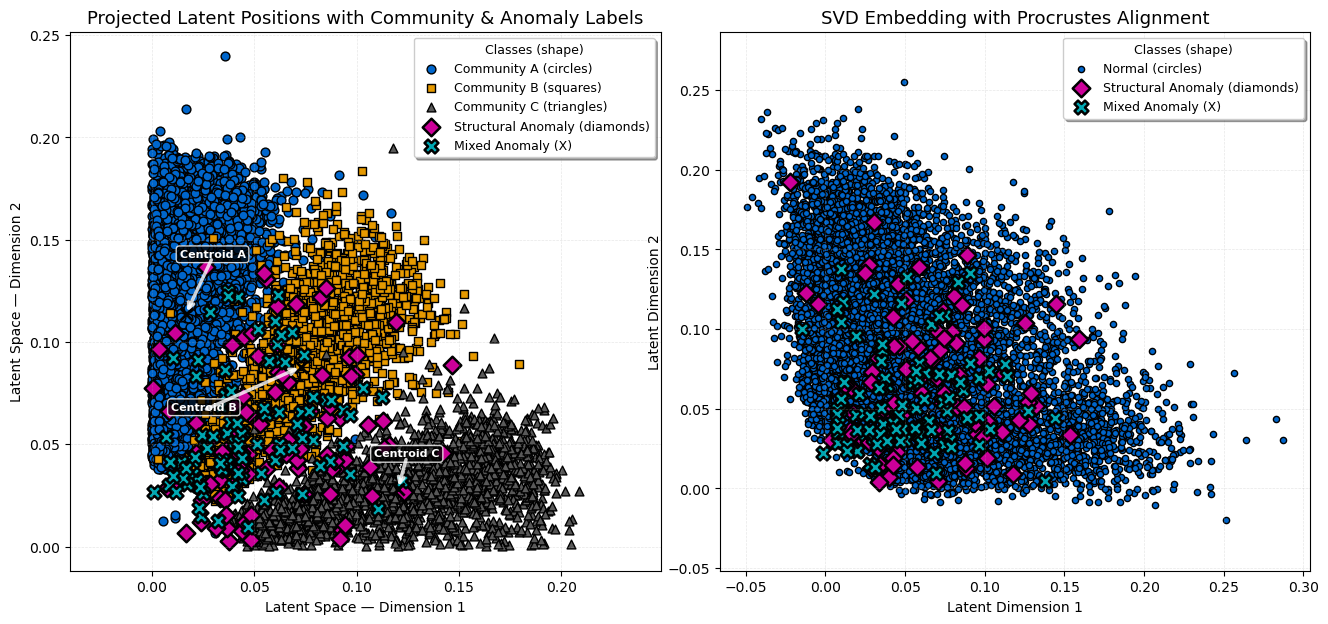

In [8]:
# --- Side-by-side plots with independent limits ---

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- LEFT PLOT: Latent (no forced limits) ---
community_labels = (
    ['A'] * X1_count +
    ['B'] * X2_count +
    ['C'] * X3_count +
    ['Structural'] * n_pure_anomalies +
    ['Mixed'] * n_mixed_anomalies
)

community_colour_map = {
    'A': (0.0, 0.4, 0.8),            
    'B': (0.9, 0.6, 0.0),            
    'C': (0.35, 0.35, 0.35),         
    'Structural': (0.8, 0.0, 0.6),   
    'Mixed': (0.0, 0.66, 0.70)       
}

community_marker_map = {
    'A': 'o', 'B': 's', 'C': '^', 'Structural': 'D', 'Mixed': 'X'
}

community_size_map = {
    'A': 40, 'B': 40, 'C': 40, 'Structural': 80, 'Mixed': 100
}

edge = lambda lbl: 'black'
lw   = lambda lbl: 1.0 if lbl in ['A','B','C'] else 1.8

# Plot each category on the left subplot
for label in community_colour_map.keys():
    mask = [i for i, l in enumerate(community_labels) if l == label]
    if mask:
        ax1.scatter(
            X_final[mask, 0], X_final[mask, 1],
            c=[community_colour_map[label]],
            s=community_size_map[label],
            alpha=1.0,
            marker=community_marker_map[label],
            edgecolors=edge(label),
            linewidths=lw(label),
            label=(f'Community {label} ({ {"A":"circles","B":"squares","C":"triangles"}[label] })'
                   if label in ['A','B','C']
                   else (f'{label} Anomaly ({ {"Structural":"diamonds","Mixed":"X"}[label] })'))
        )

ax1.set_title("Projected Latent Positions with Community & Anomaly Labels", fontsize=13)
ax1.set_xlabel("Latent Space — Dimension 1")
ax1.set_ylabel("Latent Space — Dimension 2")
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
ax1.set_aspect('equal', adjustable='datalim')  # Each plot keeps its own natural aspect

ax1.legend(
    loc='best', fontsize=9, frameon=True, fancybox=True, shadow=True,
    title="Classes (shape)", title_fontsize=9, markerscale=1.0, scatterpoints=1
)

# Add centroids and annotations
km = KMeans(n_clusters=3, random_state=42).fit(X_final[:, :2])
centroids_2d = km.cluster_centers_

X1_proj = X_final[:X1_count, :2]
X2_proj = X_final[X1_count:X1_count+X2_count, :2]
X3_proj = X_final[X1_count+X2_count:X1_count+X2_count+X3_count, :2]
true_means = np.array([X1_proj.mean(axis=0), X2_proj.mean(axis=0), X3_proj.mean(axis=0)])

dist_matrix = distance.cdist(centroids_2d, true_means)
row_ind, col_ind = linear_sum_assignment(dist_matrix)
label_lookup = {i: chr(65 + j) for i, j in zip(row_ind, col_ind)}

for i, (x, y) in enumerate(centroids_2d):
    label = label_lookup[i]
    ax1.text(
        x, y, f'Centroid {label}',
        fontsize=8, fontweight='bold', ha='center', color='white',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.8, edgecolor='white')
    )

for i in range(3):
    centroid = centroids_2d[i]
    matched_mean = true_means[col_ind[i]]
    ax1.annotate(
        "", xy=matched_mean, xytext=centroid,
        arrowprops=dict(arrowstyle="->", color='white', linewidth=2.5, alpha=0.8)
    )

ax1.scatter(true_means[:, 0], true_means[:, 1], c='black', s=80, marker='x', 
           linewidths=2, label='True Means')

# --- RIGHT PLOT: SVD ---
colour_normal = (0.0, 0.4, 0.8)        
colour_structural = (0.8, 0.0, 0.6)    
colour_mixed = (0.0, 0.66, 0.70)       

marker_normal = 'o'        
marker_structural = 'D'    
marker_mixed = 'X'         

size_normal = 20           
size_structural = 80       
size_mixed = 100           

edge_color = lambda is_anomaly: 'black'
edge_width = lambda is_anomaly: 1.8 if is_anomaly else 1.0

# Normal nodes
ax2.scatter(
    X_svd_aligned_full[true_labels == 0, 0],
    X_svd_aligned_full[true_labels == 0, 1],
    label="Normal (circles)",
    c=[colour_normal],
    s=size_normal,
    marker=marker_normal,
    edgecolors=edge_color(False),
    linewidths=edge_width(False),
    alpha=1.0
)

# Structural anomalies
ax2.scatter(
    X_svd_aligned_full[true_labels == 1, 0],
    X_svd_aligned_full[true_labels == 1, 1],
    label="Structural Anomaly (diamonds)",
    c=[colour_structural],
    s=size_structural,
    marker=marker_structural,
    edgecolors=edge_color(True),
    linewidths=edge_width(True),
    alpha=1.0
)

# Mixed anomalies
ax2.scatter(
    X_svd_aligned_full[true_labels == 2, 0],
    X_svd_aligned_full[true_labels == 2, 1],
    label="Mixed Anomaly (X)",
    c=[colour_mixed],
    s=size_mixed,
    marker=marker_mixed,
    edgecolors=edge_color(True),
    linewidths=edge_width(True),
    alpha=1.0
)

ax2.set_title("SVD Embedding with Procrustes Alignment", fontsize=13)
ax2.set_xlabel("Latent Dimension 1")
ax2.set_ylabel("Latent Dimension 2")
ax2.legend(
    loc='best', fontsize=9, frameon=True, fancybox=True, shadow=True,
    title="Classes (shape)", title_fontsize=9, markerscale=1.0, scatterpoints=1
)
ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
ax2.set_aspect('equal', adjustable='datalim')  # Each plot keeps its own natural aspect

# Save the combined figure
plt.subplots_adjust(wspace=0.10)  # Reduce space between plots
fig.savefig("combined_independent_limits.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### <u>Optimal Cluster Number Selection (on SVD Embedding)</u>

We assess the optimal number of clusters $ k \in [2, 9] $ using three common unsupervised metrics.

---

#### Metrics Evaluated

1. **K-Means Inertia (Elbow Method)**  
   - Measures total within-cluster variance.  
   - Lower values are better, but the *elbow* point indicates where further gains diminish.  

2. **Silhouette Score**  
   - Quantifies the separation between clusters.  
   - Ranges from −1 to 1; higher values indicate more distinct clusters.  
   - The best value is highlighted by a vertical dashed line in **magenta**.  

3. **Gaussian Mixture Model (GMM): AIC and BIC**  
   - **AIC (Akaike Information Criterion)** and **BIC (Bayesian Information Criterion)** balance model fit with complexity penalties.  
   - Lower values indicate better model fit with complexity control.  
   - Minima are highlighted by vertical dashed lines in **orange** (AIC) and **blue** (BIC).  

---

#### Visual Summary

- **Left**: K-Means inertia vs. $ k $ (Elbow Method)  
- **Middle**: Silhouette score with best $ k $ marked in magenta  
- **Right**: GMM AIC/BIC vs. $ k $ with minima indicated (blue for BIC, orange for AIC)  

---

#### Observations

- Silhouette suggests $k =$ *value of* `best_k_sil`.  
- BIC minimum at $k =$ *value of* `min_bic_k`.  
- AIC minimum at $k =$ *value of* `min_aic_k`.  

---

#### Example Output Stats

```text
Top silhouette score: best_k_sil = <value printed>
BIC minimum: min_bic_k = <value printed>, BIC = <value printed>
AIC minimum: min_aic_k = <value printed>, AIC = <value printed>
SVD-aligned mean: <vector of values>
SVD-aligned std: <vector of values>

---

k=2: Silhouette Score = 0.200
k=3: Silhouette Score = 0.189
k=4: Silhouette Score = 0.185
k=5: Silhouette Score = 0.202
k=6: Silhouette Score = 0.212
k=7: Silhouette Score = 0.214
k=8: Silhouette Score = 0.218
k=9: Silhouette Score = 0.162


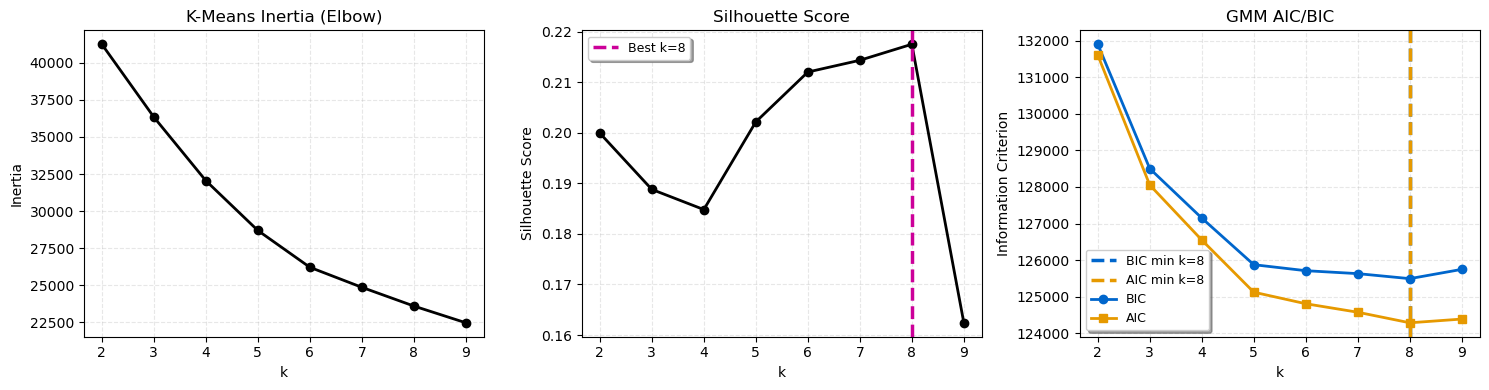

Suggested optimal k based on silhouette score: 8

Suggested optimal k based on minimum BIC: 8 (BIC=125493.43)
Suggested optimal k based on minimum AIC: 8 (AIC=124286.00)

Sample AIC: [131607.22385170625, 128053.94258021892, 126549.8917927998, 125123.30206147146, 124807.13231893386, 124574.85613393919, 124285.99900907272, 124388.0956959978]

Colour-blind friendly palette used:
Silhouette: RGB(204, 0, 153) (Magenta)
BIC: RGB(0, 102, 204) (Blue)
AIC: RGB(229, 153, 0) (Orange)


In [9]:
# --- Determine the optimal k using SVD embedding ---
Xs = StandardScaler().fit_transform(X_svd_aligned_full)  # scale once

Ks = list(range(2, 10))
inertias, sil_scores, bics, aics = [], [], [], []
best_sil_score, best_k_sil = -1, None

for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(Xs)
    inertias.append(km.inertia_)
    sil = silhouette_score(Xs, km.labels_)
    sil_scores.append(sil)
    if sil > best_sil_score:
        best_sil_score, best_k_sil = sil, k
    print(f"k={k}: Silhouette Score = {sil:.3f}")
    
    gm = GaussianMixture(
        n_components=k, covariance_type="full",
        n_init=10, max_iter=1000, reg_covar=1e-6,
        init_params="kmeans", random_state=42
    ).fit(Xs)
    bics.append(gm.bic(Xs))
    aics.append(gm.aic(Xs))

# --- Colour-blind friendly colour palette ---
color_silhouette = (0.8, 0.0, 0.6)  # Magenta
color_bic = (0.0, 0.4, 0.8)         # Blue
color_aic = (0.9, 0.6, 0.0)         # Orange

# --- Plotting with ax ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Elbow method
ax = axes[0]
ax.plot(Ks, inertias, marker='o', color='black', linewidth=2)
ax.set_title("K-Means Inertia (Elbow)", fontsize=12)
ax.set_xlabel("k")
ax.set_ylabel("Inertia")
ax.grid(True, linestyle='--', alpha=0.3)

# Silhouette scores
ax = axes[1]
ax.plot(Ks, sil_scores, marker='o', color='black', linewidth=2)
ax.set_title("Silhouette Score", fontsize=12)
ax.set_xlabel("k")
ax.set_ylabel("Silhouette Score")
ax.axvline(x=best_k_sil, linestyle='--', color=color_silhouette, linewidth=2.5,
           label=f'Best k={best_k_sil}')
ax.legend(loc='best', fontsize=9, frameon=True, fancybox=True, shadow=True)
ax.grid(True, linestyle='--', alpha=0.3)

# AIC / BIC
ax = axes[2]
min_bic, min_bic_k = min(bics), Ks[bics.index(min(bics))]
min_aic, min_aic_k = min(aics), Ks[aics.index(min(aics))]

ax.axvline(x=min_bic_k, linestyle='--', color=color_bic, linewidth=2.5,
           label=f'BIC min k={min_bic_k}')
ax.axvline(x=min_aic_k, linestyle='--', color=color_aic, linewidth=2.5,
           label=f'AIC min k={min_aic_k}')

ax.plot(Ks, bics, label="BIC", marker='o', color=color_bic, linewidth=2)
ax.plot(Ks, aics, label="AIC", marker='s', color=color_aic, linewidth=2)
ax.set_title("GMM AIC/BIC", fontsize=12)
ax.set_xlabel("k")
ax.set_ylabel("Information Criterion")
ax.legend(loc='best', fontsize=9, frameon=True, fancybox=True, shadow=True)
ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig("k_selection_simulated.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"Suggested optimal k based on silhouette score: {best_k_sil}")
print(f"\nSuggested optimal k based on minimum BIC: {min_bic_k} (BIC={min_bic:.2f})")
print(f"Suggested optimal k based on minimum AIC: {min_aic_k} (AIC={min_aic:.2f})")
print("\nSample AIC:", aics)

# --- Print colour verification ---
print("\nColour-blind friendly palette used:")
print(f"Silhouette: RGB{tuple(int(c * 255) for c in color_silhouette)} (Magenta)")
print(f"BIC: RGB{tuple(int(c * 255) for c in color_bic)} (Blue)")
print(f"AIC: RGB{tuple(int(c * 255) for c in color_aic)} (Orange)")

### <u>GMM and K-Means Clustering</u>

We apply **K-Means** and **Gaussian Mixture Models (GMM)** with varying $k$, to determine Silhouette-based cluster separation.

---

#### Steps

1. **Fit clusterers** on both:
   - True latent positions `X_final`
   - SVD-aligned embedding `X_svd_aligned_full`

   For each $k$, both KMeans and GMM models are fitted and their cluster labels recorded.

2. **Evaluate clustering quality**  
   - Compute the **silhouette score** for both KMeans and GMM on each embedding.  
   - Higher silhouette values indicate better cluster separation.  

3. **Visualise results (GMM-based)**  
   - Scatterplots show node positions coloured by GMM cluster assignment.  
   - Overlaid anomaly markers:  
     - **Magenta diamonds**: Structural anomalies  
     - **Teal X markers**: Mixed anomalies  
   - Cluster colours use a 5-colour, colour-blind friendly palette (blue, orange, grey, magenta, teal).  

4. **Save output**  
   - Figures saved to `Fig2_GMM_Clustering.pdf` for reference.

---

#### Notes

- KMeans results are fitted and evaluated, but only GMM clusters are visualised.  
- Legends include both cluster colours and anomaly markers for interpretability.

---

=== Silhouette Scores ===
Latent | k=2: KMeans = 0.315, GMM = 0.512
Latent | k=3: KMeans = 0.252, GMM = 0.245
Latent | k=5: KMeans = 0.221, GMM = 0.215
Latent | k=7: KMeans = 0.160, GMM = 0.178
Latent | k=9: KMeans = 0.103, GMM = 0.148
SVD | k=2: KMeans = 0.201, GMM = 0.183
SVD | k=3: KMeans = 0.190, GMM = 0.089
SVD | k=5: KMeans = 0.202, GMM = 0.052
SVD | k=7: KMeans = 0.214, GMM = 0.031
SVD | k=9: KMeans = 0.163, GMM = 0.036


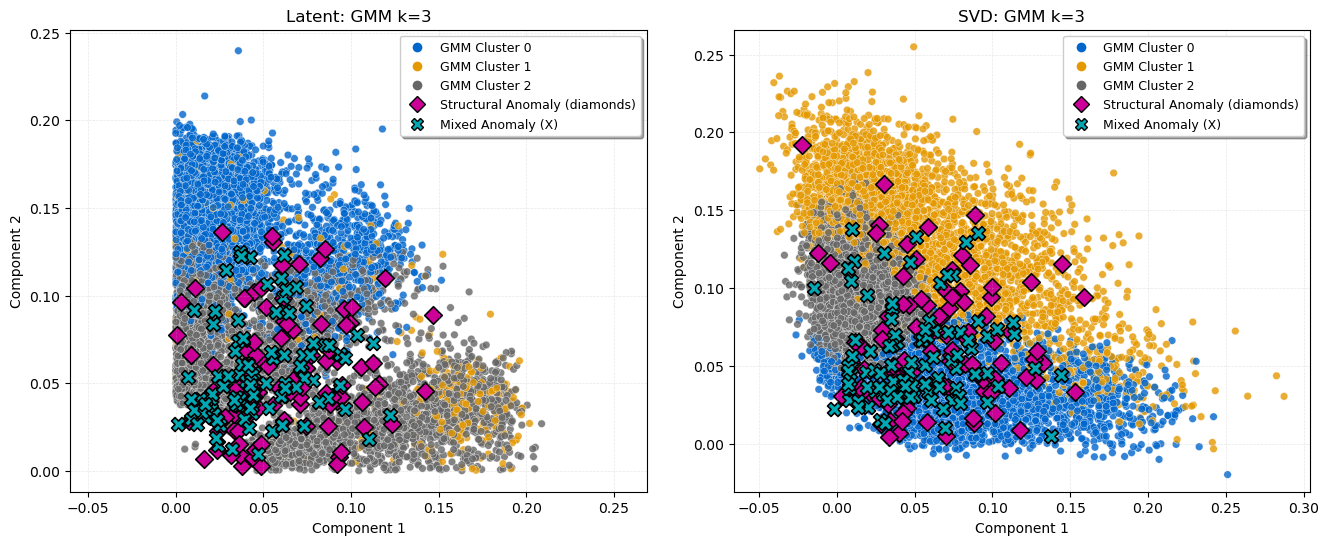

GMM cluster labels used (latent): [0 1 2]
GMM cluster labels used (svd): [0 1 2]

Colour-blind friendly palette:
Cluster colours: ['Cluster 0: #0066cc', 'Cluster 1: #e59900', 'Cluster 2: #666666']
Structural Anomaly: RGB(204, 0, 153)
Mixed Anomaly: RGB(0, 168, 178)


In [10]:
# --- Clustering Helper Function ---
def fit_clusterers(X, k_values, random_state=42, scale=True):
    """
    Fit KMeans and GMM for a list of k values.
    Returns a dictionary of results per k.
    """
    # scale once (better distances & likelihoods)
    Xs = StandardScaler().fit_transform(X) if scale else X

    # normalise k_values input
    if not isinstance(k_values, (list, tuple, np.ndarray)):
        k_values = [k_values]
    
    results = {}
    for k in (k_values if isinstance(k_values, list) else [k_values]):
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels_km = km.fit_predict(X)

        gm = GaussianMixture(n_components=k, covariance_type='full', 
                             reg_covar=1e-6, init_params='kmeans',
                             n_init=10, random_state=random_state)
        labels_gm = gm.fit_predict(Xs)

        results[k] = {
            'kmeans_labels': labels_km,
            'kmeans_centers': km.cluster_centers_,
            'gmm_labels': labels_gm,
            'gmm_model': gm
        }
    return results

# --- Parameters ---
k_list = [2, 3, 5, 7, 9]
normal_idx = (true_labels == 0)
anomaly_idx = (true_labels == 1)
mixed_idx = (true_labels == 2)

# --- Fit Clusterers ---
latent_results = fit_clusterers(X_final, k_list, random_state=42, scale=False) # Already scaled/unit ball
svd_results    = fit_clusterers(X_svd_aligned_full, k_list, random_state=42, scale=True)

# --- k selection to visualise ---
k_sel = 3 

# --- Check centres/models ---
centres_true_opt = latent_results[k_sel]['kmeans_centers']
centres_svd_opt  = svd_results[k_sel]['kmeans_centers']
gmm_true_opt     = latent_results[k_sel]['gmm_model']
gmm_svd_opt      = svd_results[k_sel]['gmm_model']

# --- Evaluate Clustering via Silhouette Scores ---
print("=== Silhouette Scores ===")
panels = [
    ('Latent', X_final,            latent_results),
    ('SVD',    X_svd_aligned_full, svd_results)
]

for name, X, result in panels:
    Xs = StandardScaler().fit_transform(X)  # match scaling used in fit_clusterers
    for k_val in k_list:
        lbl_km = result[k_val]['kmeans_labels']
        lbl_gm = result[k_val]['gmm_labels']
        sil_km = silhouette_score(Xs, lbl_km) if len(np.unique(lbl_km)) > 1 else float('nan')
        sil_gm = silhouette_score(Xs, lbl_gm) if len(np.unique(lbl_gm)) > 1 else float('nan')
        print(f"{name} | k={k_val}: KMeans = {sil_km:.3f}, GMM = {sil_gm:.3f}")

# --- Colour-blind friendly 5-cluster palette (avoid red-green conflicts) ---
cluster_colours = [
    (0.0, 0.4, 0.8),      # Blue
    (0.9, 0.6, 0.0),      # Orange  
    (0.4, 0.4, 0.4),      # Grey
    (0.8, 0.2, 0.8),      # Magenta
    (0.0, 0.6, 0.6),      # Teal
]

# Convert to hex for matplotlib compatibility
cluster_colours_hex = ['#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255)) 
                       for r, g, b in cluster_colours]

label_to_colour = {i: cluster_colours_hex[i % len(cluster_colours_hex)] for i in range(k_sel)}

# --- Anomaly colours consistent with previous plots ---
anomaly_structural_color = (0.8, 0.0, 0.6)    # Magenta (different from cluster magenta)
anomaly_mixed_color = (0.0, 0.66, 0.70)       # Teal (different from cluster teal)

# --- Plot Clustering Results ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, (name, X, idx_anom, idx_mix, result) in enumerate([
    ("Latent", X_final, anomaly_idx, mixed_idx, latent_results),
    ("SVD",    X_svd_aligned_full, anomaly_idx, mixed_idx, svd_results)
]):
    ax = axes[i]

    # GMM labels
    gmm_labels = result[k_sel]['gmm_labels']
    colours = [label_to_colour[int(lbl)] for lbl in gmm_labels]

    # Scatter of all nodes by their cluster colour
    ax.scatter(X[:, 0], X[:, 1], c=colours, s=30, alpha=0.8, edgecolors='white', linewidths=0.3)

    # Overlay anomalies with distinct colours and shapes
    ax.scatter(X[idx_anom, 0], X[idx_anom, 1],
               facecolors=anomaly_structural_color, edgecolors='black',
               s=80, linewidths=1.2, marker='D', label='Structural Anomaly')
    ax.scatter(X[idx_mix, 0], X[idx_mix, 1],
               facecolors=anomaly_mixed_color, edgecolors='black',
               s=100, linewidths=1.2, marker='X', label='Mixed Anomaly')

    ax.set_title(f"{name}: GMM k={k_sel}", fontsize=12)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
    ax.set_aspect('equal', adjustable='datalim')

    # Legend: only show cluster entries actually present in this panel
    used_labels = np.unique(gmm_labels)
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'GMM Cluster {int(label)}',
               markerfacecolor=label_to_colour[int(label)], markeredgecolor='white', markersize=8)
        for label in used_labels
    ]
    legend_elements += [
        Line2D([0], [0], marker='D', color='w', label='Structural Anomaly (diamonds)',
               markerfacecolor=anomaly_structural_color, markeredgecolor='black', markersize=8),
        Line2D([0], [0], marker='X', color='w', label='Mixed Anomaly (X)',
               markerfacecolor=anomaly_mixed_color, markeredgecolor='black', markersize=8),
    ]
    ax.legend(handles=legend_elements, loc='best', frameon=True, fontsize=9, fancybox=True, shadow=True)

plt.subplots_adjust(wspace=0.15)  # Reduce space between plots
fig.savefig("Fig2_GMM_Clustering.pdf", format='pdf', bbox_inches='tight')
plt.show()

print("GMM cluster labels used (latent):", np.unique(latent_results[k_sel]['gmm_labels']))
print("GMM cluster labels used (svd):",    np.unique(svd_results[k_sel]['gmm_labels']))

# --- Print colour verification ---
print("\nColour-blind friendly palette:")
print("Cluster colours:", [f"Cluster {i}: {color}" for i, color in label_to_colour.items()])
print(f"Structural Anomaly: RGB{tuple(int(c * 255) for c in anomaly_structural_color)}")
print(f"Mixed Anomaly: RGB{tuple(int(c * 255) for c in anomaly_mixed_color)}")

### <u>Entropy-Based Anomaly Scoring via MMSBM Approximation</u>

This section computes **soft clustering-based anomaly scores** by approximating the **Mixed-Membership Stochastic Block Model (MMSBM)** using a Gaussian Mixture Model (GMM), applied to both the **true latent positions** (`X_final`) and the **SVD-inferred embedding** (`X_svd_aligned_full`).

---

#### Key Steps

1. **GMM Soft Assignment (MMSBM Approximation)**
   - Fit a GMM with `n_communities = 3` to both latent (`X_final`) and SVD embeddings.  
   - Extract for each node:  
     - **Membership probabilities**  
     - **Entropy** as a soft anomaly score:  
       $$
       H_i = -\sum_k p_{ik} \log p_{ik}
       $$
     - **Normalised entropy**: $H_i / \log(K)$ for comparability across models  
     - **Negative log-likelihood (NLL)**:  
       $$
       \text{LL}_i = -\log P(x_i \mid \text{GMM})
       $$

2. **Distance-to-Centroid Score (KMeans)**  
   - Compute the Euclidean distance from each point to its nearest KMeans centre (using earlier cluster centres at \( k = 5 \)).

3. **Anomaly Metrics Evaluation**
   - For each score (entropy, normalised entropy, NLL, KMeans distance), compute:  
     - **AUC** (Area Under ROC)  
     - **Precision@k** and **Recall@k** for $ k \in {10, 25, 50} $  
     - Metrics are reported separately for:  
       - **Structural anomalies** (label 1)  
       - **Mixed anomalies** (label 2)  

4. **KDE Visualisation**
   - Kernel Density Estimates (KDEs) of scores per class:  
     - **Normal (blue)**  
     - **Structural (magenta)**  
     - **Mixed (teal)**  
   - Annotated with mean, median, min, and max values for interpretability.  

5. **Kolmogorov–Smirnov (KS) Tests**
   - Two-sample KS tests compare entropy distributions between groups:  
     - Normal vs Structural  
     - Normal vs Mixed  

---

#### Interpretation

- **Entropy and normalised entropy** capture role uncertainty, effective for detecting **mixed anomalies**.  
- **Negative log-likelihood** identifies points poorly explained by any mixture component, highlighting both structural and mixed outliers.  
- **KMeans distance** is competitive for detecting structural deviations from cluster centres.  
- **SVD vs Latent embeddings** comparison shows where inferred embeddings approximate the true latent space well, and where anomaly separability is reduced.  

---

#### Define Functions

In [11]:
def run_gmm_scoring(X, true_labels, n_communities=3, random_state=42):
    """
    Run GMM on latent space X to approximate MMSBM - via GM fitted to latent space:
    - Returns entropy, LL scores, and anomaly metrics.
    """
    gmm = GaussianMixture(
        n_components=n_communities, covariance_type='full',
        init_params='kmeans', n_init=10, reg_covar=1e-6,
        max_iter=1000, random_state=random_state
    ).fit(X)

    probs = gmm.predict_proba(X)
    # Entropy (raw and normalised)
    eps = 1e-12                                              # ridge term for stability
    entropy = -np.sum(probs * np.log(probs + eps), axis=1)
    entropy_norm = entropy / np.log(n_communities)
    
    # Higher = more anomalous
    ll_score = -gmm.score_samples(X)  # negative log-likelihood per sample

    # Evaluate both scores
    metrics = {
        'Structural': {
            'entropy':        evaluate_scores(entropy,      true_labels, anomaly_type_label=1, higher_is_anomalous=True),
            'entropy_norm':   evaluate_scores(entropy_norm, true_labels, anomaly_type_label=1, higher_is_anomalous=True),
            'neg_loglike':    evaluate_scores(ll_score,     true_labels, anomaly_type_label=1, higher_is_anomalous=True),
        },
        'Mixed': {
            'entropy':        evaluate_scores(entropy,      true_labels, anomaly_type_label=2, higher_is_anomalous=True),
            'entropy_norm':   evaluate_scores(entropy_norm, true_labels, anomaly_type_label=2, higher_is_anomalous=True),
            'neg_loglike':    evaluate_scores(ll_score,     true_labels, anomaly_type_label=2, higher_is_anomalous=True),
        }
    }

    return {
        'gmm_model': gmm,
        'membership_probs': probs,
        'entropy': entropy,
        'entropy_norm': entropy_norm,
        'll_score': ll_score,
        'metrics': metrics,
    }

def evaluate_scores(score_vector, true_labels, anomaly_type_label, top_k_list=(10, 25, 50), higher_is_anomalous=True):
    """
    Evaluate AUC and top-k precision/recall for a given anomaly score vector.
    higher_is_anomalous : bool
        If True, higher scores mean more anomalous (e.g., entropy, -loglik).
        If False, lower scores mean more anomalous (e.g., closeness to centroid).
        Internally, scores are reoriented so that "higher = more anomalous" for
        consistency across AUC and ranking metrics.
    """
    results = {}
    is_anomaly = (true_labels == anomaly_type_label).astype(int)
    oriented = score_vector if higher_is_anomalous else -score_vector
    if is_anomaly.sum() in (0, len(is_anomaly)):
        results['AUC'] = float('nan')
    else:
        results['AUC'] = roc_auc_score(is_anomaly, oriented)

    n = len(score_vector)
    # Sort depending on direction
    order = np.argsort(oriented, kind="stable")[::-1]

    for k in top_k_list:
        kk = min(k, n)
        pred = np.zeros_like(is_anomaly)
        pred[order[:kk]] = 1
        results[f'Precision@{k}'] = precision_score(is_anomaly, pred, zero_division=0)
        results[f'Recall@{k}']    = recall_score(is_anomaly, pred, zero_division=0)
    return results


def print_anomaly_metrics_table(metrics_dict, space_label, method_label="", leaf_key=None):
    """
    Print a formatted table of anomaly detection metrics (AUC, Precision@k, Recall@k) 
    for each anomaly type.
    """
    print(f"\n--- {space_label}" + (f" — {method_label} Entropy" if method_label else "") + " ---")
    headers = ["Anomaly Type", "AUC", "Precision@10", "Recall@10",
               "Precision@25", "Recall@25", "Precision@50", "Recall@50"]
    rows = []
    for anom_type, inner in metrics_dict.items():
        metrics = inner if leaf_key is None else inner[leaf_key]
        rows.append([anom_type] + [f"{metrics[k]:.3f}" for k in
                    ["AUC","Precision@10","Recall@10","Precision@25","Recall@25","Precision@50","Recall@50"]])
    print(tabulate(rows, headers=headers, tablefmt="github"))

# Colour-blind friendly consistent colour palette (matching previous plots)
PALETTE = {
    0: (0.0, 0.4, 0.8),      # Normal -> blue 
    1: (0.8, 0.0, 0.6),      # Structural -> magenta 
    2: (0.0, 0.66, 0.70),    # Mixed -> teal 
}
LABELS = {0: "Normal", 1: "Structural", 2: "Mixed"}

def plot_score_kdes(df, score_cols, titles, palette=PALETTE, labels=LABELS):
    """
    Plot side-by-side KDEs for score columns with colour-blind friendly colours.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must include 'true_label' and the given score columns.
    score_cols : list[str]
        Columns to plot, e.g. ['entropy_latent', 'entropy_svd'].
    titles : list[str]
        Plot titles for each subplot (same length as score_cols).
    palette : dict[int, tuple], optional
        Mapping {class_id: colour}, defaults to PALETTE.
    labels : dict[int, str], optional
        Mapping {class_id: display_name}, defaults to LABELS.
    """
    fig, axes = plt.subplots(1, len(score_cols), figsize=(7*len(score_cols), 5), sharey=False)

    # Ensure axes is iterable even for a single column
    if len(score_cols) == 1:
        axes = [axes]

    for ax, col, title in zip(axes, score_cols, titles):
        stats_lines = []
        for cls in [0, 1, 2]:
            name = labels[cls]
            colour = palette[cls]
            vals = df.loc[df['true_label'] == cls, col]
            if len(vals) == 0:
                continue

            # Use colour-blind friendly styling
            sns.kdeplot(vals, label=name, fill=True, alpha=0.7, ax=ax, color=colour, linewidth=2)

            # Stats for the annotation box
            mean = vals.mean()
            median = np.median(vals)
            vmin = vals.min()
            vmax = vals.max()
            stats_lines.append(f"{name}: μ={mean:.2f}, M={median:.2f}, min={vmin:.2f}, max={vmax:.2f}")

        ax.set_title(title, fontsize=12)
        ax.set_xlabel(col.replace('_', ' ').title())
        ax.set_ylabel('Density')
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
        
        # Enhanced legend styling
        legend = ax.legend(title="Classes", loc="upper right", frameon=True, 
                          fancybox=True, shadow=True, fontsize=10)
        legend.get_title().set_fontsize(10)

        # Enhanced stats box with better contrast
        ax.text(0.98, 0.4, "\n".join(stats_lines),
                transform=ax.transAxes, fontsize=9,
                va='bottom', ha='right',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9, 
                         edgecolor='black', linewidth=0.5))

        # Entropy is naturally non-negative; keep x-axis tidy
        if "entropy" in col.lower():
            ax.set_xlim(left=0)

    plt.tight_layout()
    plt.show()

# --- Print colour verification ---
print("Colour-blind friendly KDE palette:")
for cls, color in PALETTE.items():
    r, g, b = [int(c * 255) for c in color]
    print(f"{LABELS[cls]}: RGB({r}, {g}, {b})")
    

def print_score_stats_table(df, score_cols):
    """
    Prints a stats table (mean, median, min, max) for each score column and anomaly type.
    """
    for col in score_cols:
        print(f"\n--- Stats for {col} ---")
        headers = ["Class", "Mean", "Median", "Min", "Max"]
        table = []
        for lbl, name in zip([0, 1, 2], ['Normal', 'Structural', 'Mixed']):
            vals = df.loc[df['true_label'] == lbl, col]
            table.append([
                name,
                f"{vals.mean():.3f}",
                f"{np.median(vals):.3f}",
                f"{vals.min():.3f}",
                f"{vals.max():.3f}"
            ])
        print(tabulate(table, headers=headers, tablefmt="github"))

def run_ks_tests(entropy, true_labels, label_space=""):
    print(f"\n--- Kolmogorov–Smirnov Tests ({label_space}) ---")
    n = entropy[true_labels == 0]
    s = entropy[true_labels == 1]
    m = entropy[true_labels == 2]
    if len(n) and len(s):
        ks_struct = ks_2samp(n, s)
        print(f"Normal vs Structural: D = {ks_struct.statistic:.3f}, p = {ks_struct.pvalue:.2e}")
    else:
        print("Normal vs Structural: insufficient samples")
    if len(n) and len(m):
        ks_mixed = ks_2samp(n, m)
        print(f"Normal vs Mixed:      D = {ks_mixed.statistic:.3f}, p = {ks_mixed.pvalue:.2e}")
    else:
        print("Normal vs Mixed:      insufficient samples")

Colour-blind friendly KDE palette:
Normal: RGB(0, 102, 204)
Structural: RGB(204, 0, 153)
Mixed: RGB(0, 168, 178)


#### Run Scoring

In [12]:
# === GMM scoring on latent and SVD ===

k_kmeans_dist_gmm_nll = 2   # silhouette-based choice
k_gmm_entropy         = 3   # matches macro-roles (A/B/C)

# --- KMeans for anomaly distances ---
# Latent space: already normalised (unit ball), no scaling
km_lat = KMeans(n_clusters=k_kmeans_dist_gmm_nll, n_init=10, random_state=42).fit(X_final)
centres_true_opt = km_lat.cluster_centers_

# SVD space: arbitrary scaling, apply standardisation
sc_svd = StandardScaler().fit(X_svd_aligned_full)
Xs_svd = sc_svd.transform(X_svd_aligned_full)
km_svd = KMeans(n_clusters=k_kmeans_dist_gmm_nll, n_init=10, random_state=42).fit(Xs_svd)
centres_svd_opt = km_svd.cluster_centers_

# --- GMM for entropy analysis ---
# Latent: fit directly (no scaling needed)
gmm_latent = run_gmm_scoring(X_final, true_labels, n_communities=k_gmm_entropy)

# SVD: fit on raw SVD 
gmm_svd = run_gmm_scoring(X_svd_aligned_full, true_labels, n_communities=k_gmm_entropy)

# Clip entropy values to theoretical maximum log(k)
gmm_latent['entropy'] = np.clip(gmm_latent['entropy'], 0, np.log(k_gmm_entropy))
gmm_svd['entropy']    = np.clip(gmm_svd['entropy'],    0, np.log(k_gmm_entropy))

# --- KMeans anomaly scores ---
# Distances in the same space as fitted centres
kmeans_dist_latent = pairwise_distances(X_final, centres_true_opt).min(axis=1)   # latent raw
kmeans_dist_svd    = pairwise_distances(Xs_svd, centres_svd_opt).min(axis=1)    # svd scaled

# --- Combined Score DataFrame ---
anomaly_score_df = pd.DataFrame({
    'true_label': true_labels,
    'kmeans_dist_latent': kmeans_dist_latent,
    'kmeans_dist_svd': kmeans_dist_svd,
    'gmm_score_latent': gmm_latent['ll_score'],     # higher = more anomalous
    'gmm_score_svd': gmm_svd['ll_score'],
    'entropy_latent_norm': gmm_latent['entropy_norm'],
    'entropy_svd_norm': gmm_svd['entropy_norm'],
})

# --- Metrics ---
kmeans_latent_metrics = {
    "Structural": evaluate_scores(anomaly_score_df['kmeans_dist_latent'], true_labels, 1, higher_is_anomalous=True),
    "Mixed":      evaluate_scores(anomaly_score_df['kmeans_dist_latent'], true_labels, 2, higher_is_anomalous=True),
}
gmm_latent_metrics = {
    "Structural": evaluate_scores(anomaly_score_df['gmm_score_latent'], true_labels, 1, higher_is_anomalous=True),
    "Mixed":      evaluate_scores(anomaly_score_df['gmm_score_latent'], true_labels, 2, higher_is_anomalous=True),
}
kmeans_svd_metrics = {
    "Structural": evaluate_scores(anomaly_score_df['kmeans_dist_svd'], true_labels, 1, higher_is_anomalous=True),
    "Mixed":      evaluate_scores(anomaly_score_df['kmeans_dist_svd'], true_labels, 2, higher_is_anomalous=True),
}
gmm_svd_metrics = {
    "Structural": evaluate_scores(anomaly_score_df['gmm_score_svd'], true_labels, 1, higher_is_anomalous=True),
    "Mixed":      evaluate_scores(anomaly_score_df['gmm_score_svd'], true_labels, 2, higher_is_anomalous=True),
}

# --- Normalised entropy metrics ---
entropy_latent_metrics = {
    "Structural": evaluate_scores(anomaly_score_df['entropy_latent_norm'], true_labels, 1, higher_is_anomalous=True),
    "Mixed":      evaluate_scores(anomaly_score_df['entropy_latent_norm'], true_labels, 2, higher_is_anomalous=True),
}
entropy_svd_metrics = {
    "Structural": evaluate_scores(anomaly_score_df['entropy_svd_norm'], true_labels, 1, higher_is_anomalous=True),
    "Mixed":      evaluate_scores(anomaly_score_df['entropy_svd_norm'], true_labels, 2, higher_is_anomalous=True),
}

#### Results Tabules and Plotting


--- Stats for entropy_latent_norm ---
| Class      |   Mean |   Median |   Min |   Max |
|------------|--------|----------|-------|-------|
| Normal     |  0.164 |    0.051 |    -0 | 0.965 |
| Structural |  0.001 |   -0     |    -0 | 0.129 |
| Mixed      |  0.216 |    0.083 |     0 | 0.908 |

--- Stats for entropy_svd_norm ---
| Class      |   Mean |   Median |   Min |   Max |
|------------|--------|----------|-------|-------|
| Normal     |  0.255 |    0.183 |    -0 | 0.999 |
| Structural |  0.304 |    0.312 |     0 | 0.775 |
| Mixed      |  0.36  |    0.414 |     0 | 0.864 |

--- Stats for gmm_score_latent ---
| Class      |    Mean |   Median |     Min |    Max |
|------------|---------|----------|---------|--------|
| Normal     | -15.349 |  -15.934 | -18.5   | -0.371 |
| Structural |  -4.344 |   -5.933 |  -8.581 |  6.867 |
| Mixed      | -14.003 |  -14.485 | -18.261 | -8.373 |

--- Stats for gmm_score_svd ---
| Class      |   Mean |   Median |     Min |    Max |
|------------|---

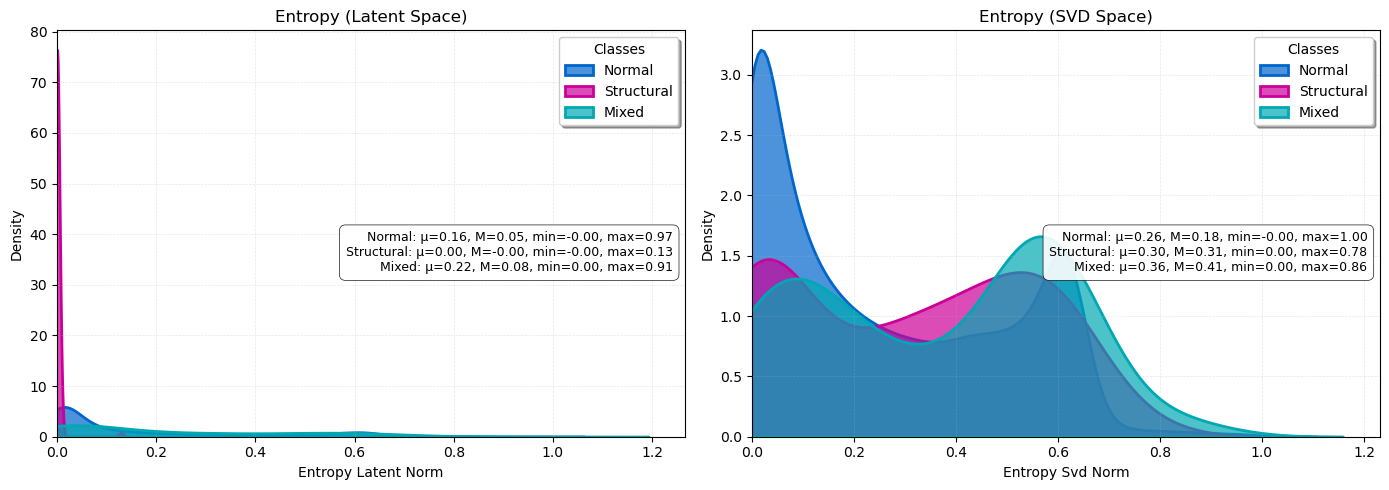

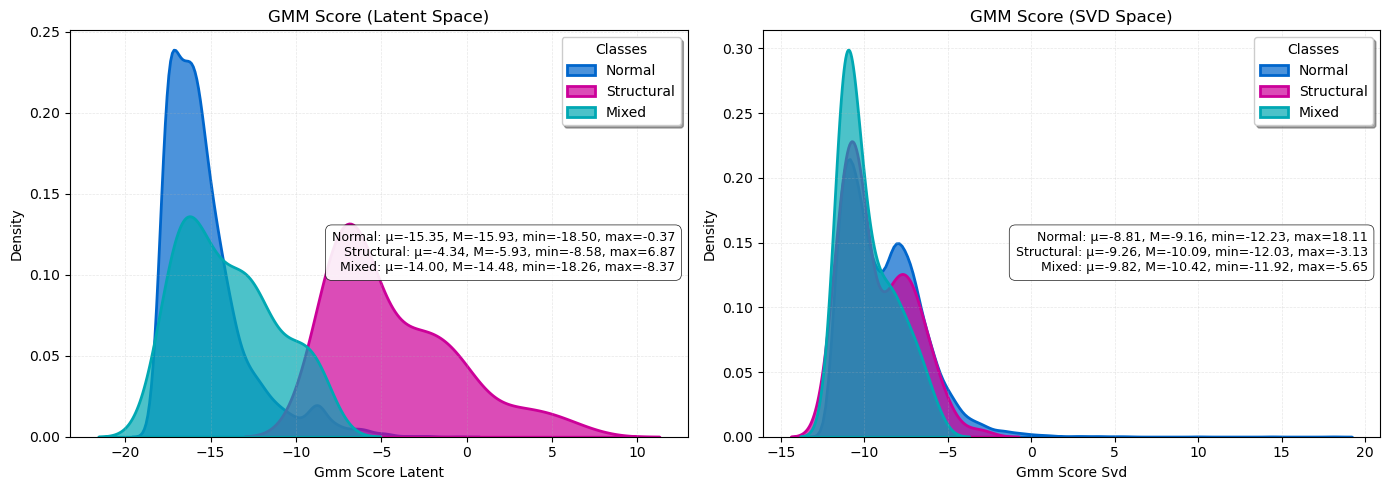

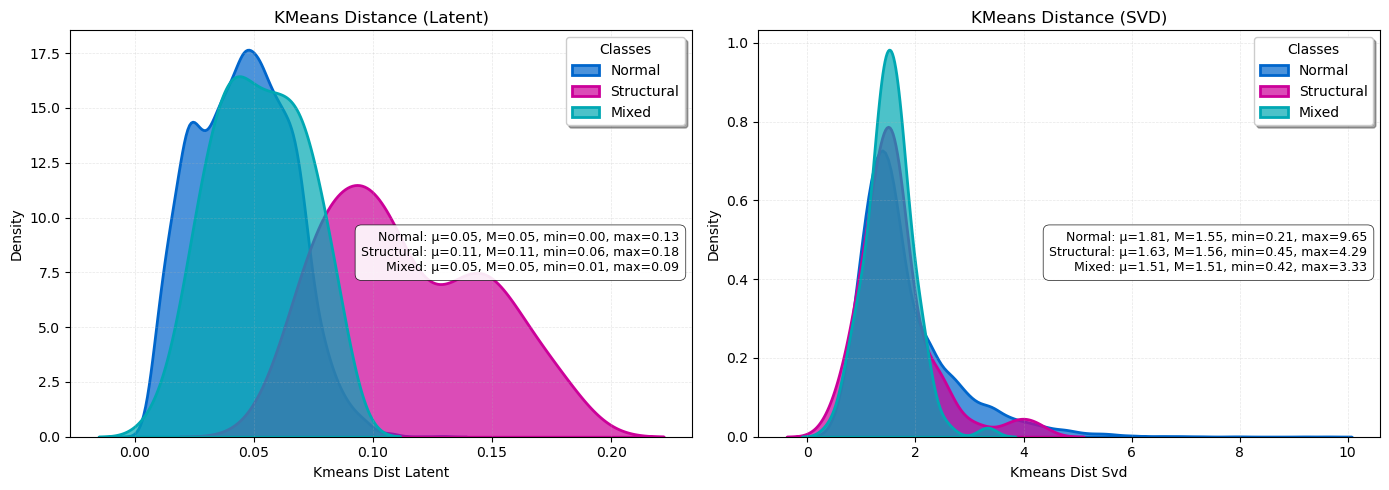


--- Latent Space — GMM Entropy ---
| Anomaly Type   |   AUC |   Precision@10 |   Recall@10 |   Precision@25 |   Recall@25 |   Precision@50 |   Recall@50 |
|----------------|-------|----------------|-------------|----------------|-------------|----------------|-------------|
| Structural     | 0.011 |            0   |        0    |           0    |        0    |           0    |        0    |
| Mixed          | 0.566 |            0.1 |        0.01 |           0.08 |        0.02 |           0.08 |        0.04 |

--- SVD Space — GMM Entropy ---
| Anomaly Type   |   AUC |   Precision@10 |   Recall@10 |   Precision@25 |   Recall@25 |   Precision@50 |   Recall@50 |
|----------------|-------|----------------|-------------|----------------|-------------|----------------|-------------|
| Structural     | 0.549 |              0 |           0 |              0 |           0 |           0    |        0    |
| Mixed          | 0.628 |              0 |           0 |              0 |           0 |   

In [13]:
# === Print Score Stats ===
print_score_stats_table(anomaly_score_df, [
    'entropy_latent_norm', 'entropy_svd_norm',
    'gmm_score_latent', 'gmm_score_svd',
    'kmeans_dist_latent', 'kmeans_dist_svd'
])

print()

# === KDE Plots ===
plot_score_kdes(
    anomaly_score_df,
    score_cols=['entropy_latent_norm', 'entropy_svd_norm'],
    titles=["Entropy (Latent Space)", "Entropy (SVD Space)"]
)

plot_score_kdes(
    anomaly_score_df,
    score_cols=['gmm_score_latent', 'gmm_score_svd'],
    titles=["GMM Score (Latent Space)", "GMM Score (SVD Space)"]
)

plot_score_kdes(
    anomaly_score_df,
    score_cols=['kmeans_dist_latent', 'kmeans_dist_svd'],
    titles=["KMeans Distance (Latent)", "KMeans Distance (SVD)"]
)

# === Metrics Tables ===
print_anomaly_metrics_table(gmm_latent['metrics'], "Latent Space", "GMM", leaf_key="entropy_norm")
print_anomaly_metrics_table(gmm_svd['metrics'], "SVD Space", "GMM", leaf_key="entropy_norm")

# === KS Tests ===
run_ks_tests(gmm_latent['entropy_norm'], true_labels, "Latent Space")
run_ks_tests(gmm_svd['entropy_norm'], true_labels, "SVD Space")

# === KMeans and GMM Metrics (Latent) ===
print_anomaly_metrics_table(kmeans_latent_metrics, "KMeans Distance (Latent)")
print_anomaly_metrics_table(gmm_latent_metrics, "GMM Log-Likelihood (Latent)")

print()

# === KMeans and GMM Metrics (SVD) ===
print_anomaly_metrics_table(kmeans_svd_metrics, "KMeans Distance (SVD)")
print_anomaly_metrics_table(gmm_svd_metrics, "GMM Log-Likelihood (SVD)")

### <u>Empirical p-value Analysis for Anomaly Scores</u>

This section evaluates the **calibration** of anomaly scores by converting them into **empirical CDF p-values** and testing their uniformity against the uniform distribution.

---

#### Workflow

1. **Convert scores to empirical p-values**  
   - Sort the score array and compute percentile ranks:  
     $$
     p_i = \frac{\#\{j : s_j \leq s_i\}}{n}
     $$
   - If higher values indicate stronger anomalies, invert scores before ranking (`inverse=True`).  

2. **Overall calibration check**  
   - Plot histogram of all `pvals` using a colour-blind friendly palette (Normal -> blue).  
   - Perform a **Kolmogorov–Smirnov one-sample test** against $U[0,1]$ to assess deviation from uniformity.  

3. **Anomaly-specific calibration** *(if labels provided)*  
   - Partition p-values by class label:  
     - **Structural anomalies** (magenta)  
     - **Mixed anomalies** (teal)  
   - Plot histograms of anomaly p-values for each group.  
   - Run KS tests separately for structural and mixed anomalies vs $U[0,1]$.  
   - Report mean p-values to summarise bias in each anomaly type.  

---

#### Interpretation

- **Uniform p-values** under the normal class indicate well-calibrated scores.  
- **Enrichment of low p-values** in anomalies shows successful separation from the normal population.  
- **KS test results** quantify miscalibration and highlight differences between structural and mixed anomalies.  

---

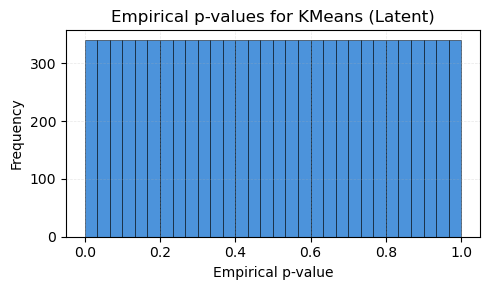

KS test vs. U[0,1] for KMeans (Latent) -> D = 0.000, p = 1.000e+00


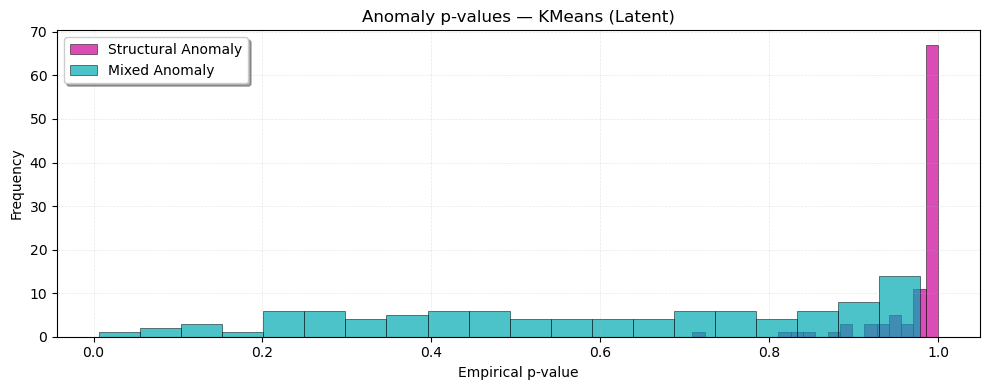

KS (Structural) -> D = 0.840, p = 1.222e-79
KS (Mixed) -> D = 0.144, p = 2.922e-02
Mean p-value (Structural): 0.975
Mean p-value (Mixed): 0.593


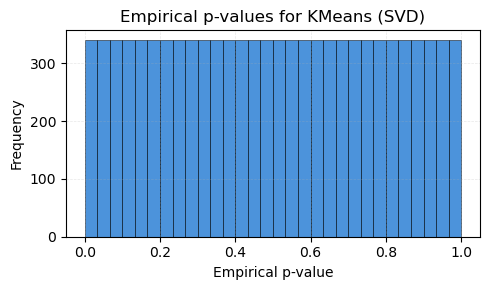

KS test vs. U[0,1] for KMeans (SVD) -> D = 0.000, p = 1.000e+00


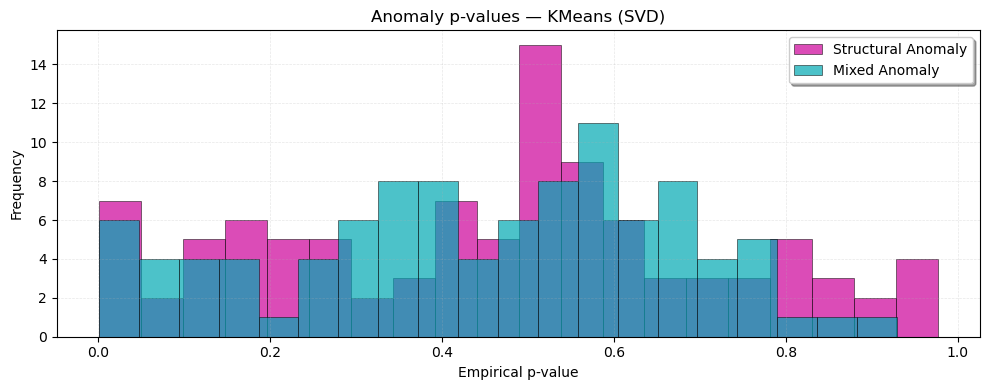

KS (Structural) -> D = 0.145, p = 2.633e-02
KS (Mixed) -> D = 0.204, p = 3.915e-04
Mean p-value (Structural): 0.465
Mean p-value (Mixed): 0.443


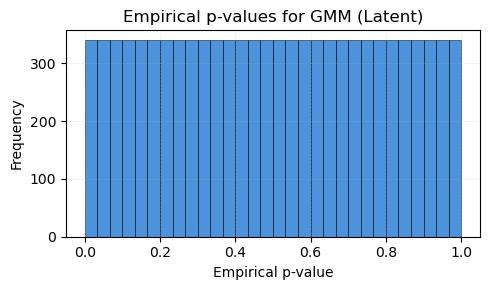

KS test vs. U[0,1] for GMM (Latent) -> D = 0.000, p = 1.000e+00


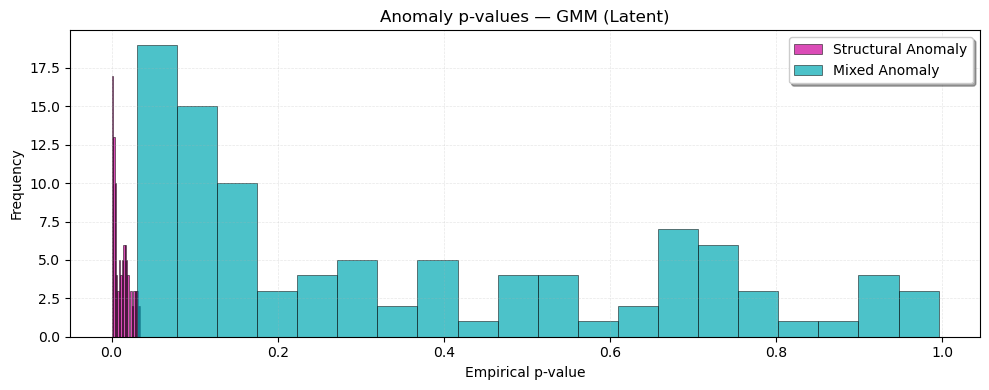

KS (Structural) -> D = 0.965, p = 2.195e-146
KS (Mixed) -> D = 0.267, p = 8.420e-07
Mean p-value (Structural): 0.012
Mean p-value (Mixed): 0.360


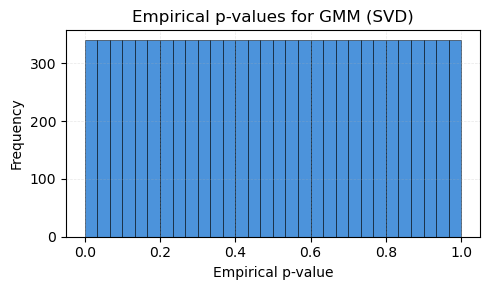

KS test vs. U[0,1] for GMM (SVD) -> D = 0.000, p = 1.000e+00


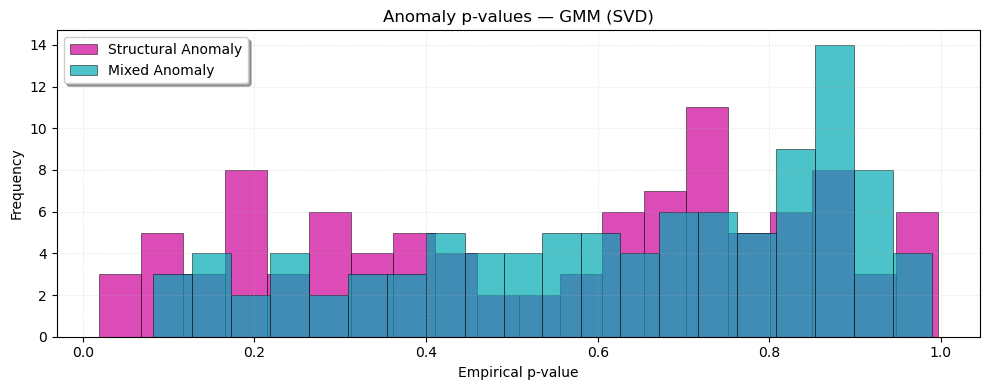

KS (Structural) -> D = 0.137, p = 4.276e-02
KS (Mixed) -> D = 0.214, p = 1.732e-04
Mean p-value (Structural): 0.550
Mean p-value (Mixed): 0.629


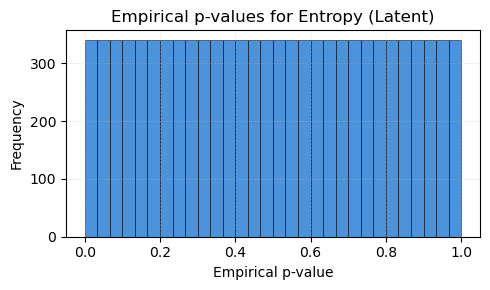

KS test vs. U[0,1] for Entropy (Latent) -> D = 0.008, p = 5.706e-01


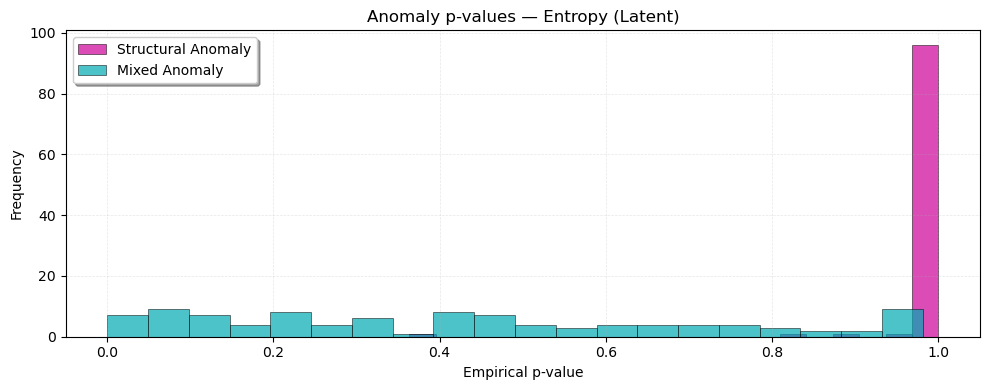

KS (Structural) -> D = 0.940, p = 7.994e-123
KS (Mixed) -> D = 0.136, p = 4.589e-02
Mean p-value (Structural): 0.987
Mean p-value (Mixed): 0.434


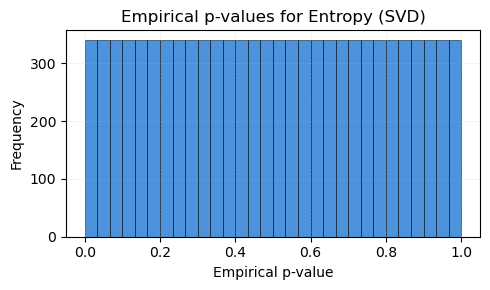

KS test vs. U[0,1] for Entropy (SVD) -> D = 0.000, p = 1.000e+00


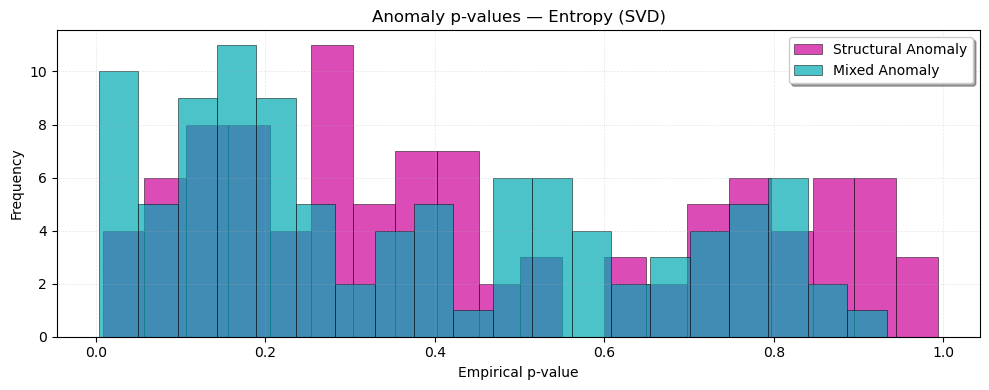

KS (Structural) -> D = 0.157, p = 1.259e-02
KS (Mixed) -> D = 0.226, p = 5.565e-05
Mean p-value (Structural): 0.452
Mean p-value (Mixed): 0.374

Colour-blind friendly palette used:
Normal: RGB(0, 102, 204)
Structural: RGB(204, 0, 153)
Mixed: RGB(0, 168, 178)


In [14]:
def analyse_empirical_pvals(score_array, label_array=None, inverse=False, name='Score', show_anomalies=True):
    """
    Compute and plot empirical CDF p-values, perform KS test vs. U[0,1],
    and optionally analyse anomaly-specific p-values with colour-blind friendly colour scheme.
    
    Colour-blind friendly colours:
        Normal       -> Blue    (0.0, 0.4, 0.8)
        Structural   -> Magenta (0.8, 0.0, 0.6)
        Mixed        -> Teal    (0.0, 0.66, 0.70)
    """
    # Colour palette (consistent with other plots)
    colors = {
        'normal': (0.0, 0.4, 0.8),      # Blue
        'structural': (0.8, 0.0, 0.6),  # Magenta
        'mixed': (0.0, 0.66, 0.70)      # Teal
    }
    
    # Inversion (optional) if higher score = more anomalous
    scores = -score_array if inverse else score_array
    sorted_scores = np.sort(scores)
    pvals = np.searchsorted(sorted_scores, scores, side='right') / len(scores)
    
    # Overall histogram with consistent styling
    plt.figure(figsize=(5, 3))
    plt.hist(pvals, bins=30, edgecolor='black', alpha=0.7, color=colors['normal'], linewidth=0.5)
    plt.title(f"Empirical p-values for {name}", fontsize=12)
    plt.xlabel("Empirical p-value")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # KS test overall
    ks_stat, ks_pval = ks_1samp(pvals, uniform.cdf)
    print(f"KS test vs. U[0,1] for {name} -> D = {ks_stat:.3f}, p = {ks_pval:.3e}")

    if label_array is not None and show_anomalies:
        # Anomaly-specific p-values
        structural_p = pvals[label_array == 1]
        mixed_p = pvals[label_array == 2]

        # Plot anomaly histograms with colour-blind friendly colours
        plt.figure(figsize=(10, 4))
        plt.hist(structural_p, bins=20, alpha=0.7, label='Structural Anomaly',
                 edgecolor='black', color=colors['structural'], linewidth=0.5)
        plt.hist(mixed_p, bins=20, alpha=0.7, label='Mixed Anomaly',
                 edgecolor='black', color=colors['mixed'], linewidth=0.5)
        plt.title(f"Anomaly p-values — {name}", fontsize=12)
        plt.xlabel("Empirical p-value")
        plt.ylabel("Frequency")
        
        # Enhanced legend styling
        legend = plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=10)
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # KS test for anomalies
        ks_struct = ks_1samp(structural_p, uniform.cdf)
        ks_mixed = ks_1samp(mixed_p, uniform.cdf)

        print(f"KS (Structural) -> D = {ks_struct.statistic:.3f}, p = {ks_struct.pvalue:.3e}")
        print(f"KS (Mixed) -> D = {ks_mixed.statistic:.3f}, p = {ks_mixed.pvalue:.3e}")
        print(f"Mean p-value (Structural): {structural_p.mean():.3f}")
        print(f"Mean p-value (Mixed): {mixed_p.mean():.3f}")

    return pvals

# True labels: 0 = normal, 1 = structural, 2 = mixed
labels = true_labels

# Run analyses with colour-blind friendly visualisations
analyse_empirical_pvals(anomaly_score_df['kmeans_dist_latent'], anomaly_score_df['true_label'], 
                       inverse=False, name="KMeans (Latent)")
analyse_empirical_pvals(anomaly_score_df['kmeans_dist_svd'], anomaly_score_df['true_label'], 
                       inverse=False, name="KMeans (SVD)")
analyse_empirical_pvals(anomaly_score_df['gmm_score_latent'], anomaly_score_df['true_label'], 
                       inverse=True, name="GMM (Latent)")
analyse_empirical_pvals(anomaly_score_df['gmm_score_svd'], anomaly_score_df['true_label'], 
                       inverse=True, name="GMM (SVD)")
analyse_empirical_pvals(anomaly_score_df['entropy_latent_norm'], anomaly_score_df['true_label'], 
                       inverse=True, name="Entropy (Latent)")
analyse_empirical_pvals(anomaly_score_df['entropy_svd_norm'], anomaly_score_df['true_label'], 
                       inverse=True, name="Entropy (SVD)")

# --- Print colour verification ---
print("\nColour-blind friendly palette used:")
colors_verification = {
    'Normal': (0.0, 0.4, 0.8),
    'Structural': (0.8, 0.0, 0.6), 
    'Mixed': (0.0, 0.66, 0.70)
}
for label, color in colors_verification.items():
    r, g, b = [int(c * 255) for c in color]
    print(f"{label}: RGB({r}, {g}, {b})")

### SVD Ablation Study for ASE (Adjacency Spectral Embedding)

This experiment evaluates the robustness of **Adjacency Spectral Embedding (ASE)** under different embedding dimensions \(d\) and GMM macro-community counts \(k\).  We assess anomaly detection performance using **entropy-based mixed anomaly AUC**.

---

#### Workflow

1. **Symmetrisation of Adjacency Matrix**
   - Ensure the adjacency matrix \(A\) is symmetric and diagonal-free:
     $$
     A \leftarrow \tfrac{1}{2}(A + A^\top), \quad \text{diag}(A) = 0
     $$

2. **ASE via SVD**
   - Compute top-\(d\) ASE embedding:
     $$
     X = U \sqrt{\Sigma}
     $$
     - Use **`scipy.sparse.linalg.svds`** if \(>85\%\) entries are zero, otherwise full SVD.  
     - Always compute up to $\max(Ds)$ once, then truncate to smaller \(d\).

3. **Entropy-based Mixed Anomaly Scoring**
   - Fit a **Gaussian Mixture Model (GMM)** with \(k\) macro-components.  
   - Compute per-node entropy:
     $$
     H_i = - \sum_{c=1}^k p_{ic} \log p_{ic}
     $$
     - Normalised by $\log k$.  
   - Evaluate AUC against **mixed anomaly labels**.

4. **Base Case**
   - Evaluate **latent vs SVD embedding** at baseline \(d=5\), \(k=3\).

5. **Sensitivity in \(k\)**
   - Test entropy-based AUC for multiple values of \(k\) (e.g. \(k=3,5\)) at fixed \(d=5\).

6. **Ablation over \(d\)**
   - Fix macro-community count \(k=3\).  
   - Evaluate mixed anomaly AUC across varying SVD dimensions: $d \in \{3, 5, 7, 10\}$.

---

#### Output

- **Base Case**: Comparison of latent vs SVD entropy AUC.  
- **Sensitivity**: Mixed anomaly AUC as a function of \(k\).  
- **Ablation**: Mixed anomaly AUC as a function of \(d\).  

This study highlights how embedding dimension and community hyperparameters affect the separability of mixed anomalies in ASE embeddings.

---

In [15]:
# --- Prep & helpers ----------------------------------------------------------

def enforce_symmetry(A: np.ndarray) -> np.ndarray:
    A = A.astype(np.float32, copy=False)
    A = 0.5 * (A + A.T)              # defensive symmetrisation
    np.fill_diagonal(A, 0.0)
    return A

def ase_svd(A_mat: np.ndarray, d: int, use_sparse: bool) -> np.ndarray:
    """Adjacency Spectral Embedding via SVD: X = U * sqrt(S)."""
    d_safe = int(min(d, min(A_mat.shape) - 1))  # guard for svds
    if use_sparse:
        U, S, VT = svds(sp.csr_matrix(A_mat), k=d_safe)
        U, S, VT = U[:, ::-1], S[::-1], VT[::-1, :]
    else:
        U, S, VT = svd(A_mat, full_matrices=False)
        U, S, VT = U[:, :d_safe], S[:d_safe], VT[:d_safe, :]
    X = U @ np.diag(np.sqrt(S.astype(np.float32)))
    return X.astype(np.float32)

def gmm_entropy_auc(
    X: np.ndarray,
    k_components: int,
    y_true: np.ndarray,
    *,
    normalised: bool = True,
    seed: int = 42,
    scale: bool = True,
) -> float:
    """Fit GMM on X, compute (normalised) membership entropy AUC for 'mixed' anomalies."""
    Xs = StandardScaler().fit_transform(X) if scale else X
    gm = GaussianMixture(
        n_components=k_components,
        covariance_type='full',
        init_params='kmeans',
        n_init=10,
        max_iter=1000,
        reg_covar=1e-6,
        random_state=seed,
    ).fit(Xs)
    probs = gm.predict_proba(Xs)
    ent = -(probs * np.log(probs + 1e-12)).sum(axis=1)
    if normalised and k_components > 1:
        ent = ent / np.log(k_components)
    y_mixed = (y_true == 2).astype(int)
    # guard: AUC undefined if all same class
    if y_mixed.sum() == 0 or y_mixed.sum() == len(y_mixed):
        return float('nan')
    return float(roc_auc_score(y_mixed, ent))

# --- Driver  ---

def run_svd_ablation(
    A: np.ndarray,
    X_latent: np.ndarray,
    y_true: np.ndarray,
    Ds=(3, 5, 7, 10),
    k_macro=3,
    k_sensitivity=(3, 5),
) -> None:
    A = enforce_symmetry(A)
    sparsity = float((A == 0).sum()) / A.size
    use_sparse = (sparsity > 0.85)
    print(f"Sparsity of A: {sparsity:.2%}  ->  {'svds' if use_sparse else 'full svd'}")

    # SVD once to max-d, then truncate for ablation
    d_max = max(Ds)
    X_svd_max = ase_svd(A, d=d_max, use_sparse=use_sparse)

    # Base case at d=5 (if present), else first in Ds
    d_base = 5 if 5 in Ds else Ds[0]
    auc_latent_base = gmm_entropy_auc(X_latent, k_macro, y_true, normalised=True, scale=False)
    auc_svd_base    = gmm_entropy_auc(X_svd_max[:, :d_base], k_macro, y_true, normalised=True, scale=False)

    print(f"\n=== Base Case (Entropy normalised) — d={d_base}, k_macro={k_macro} — Mixed AUC ===")
    print(f"Latent: {auc_latent_base:.4f}")
    print(f"SVD:    {auc_svd_base:.4f}")

    # Sensitivity in k
    for k_test in k_sensitivity:
        auc_lat_k = gmm_entropy_auc(X_latent, k_test, y_true, normalised=True, scale=False)
        auc_svd_k = gmm_entropy_auc(X_svd_max[:, :d_base], k_test, y_true, normalised=True, scale=False)
        print(f"\n[Sensitivity] Entropy (normalised) — d={d_base}, k={k_test} — Mixed AUC")
        print(f"Latent: {auc_lat_k:.4f}")
        print(f"SVD:    {auc_svd_k:.4f}")

    # Ablation over d for fixed k_macro
    print(f"\n=== Ablation over d (Entropy normalised) — k_macro={k_macro} — Mixed AUC ===")
    print(f"Latent (const.): {auc_latent_base:.4f}")
    for d_cur in Ds:
        auc_svd_d = gmm_entropy_auc(X_svd_max[:, :d_cur], k_macro, y_true, normalised=True, scale=False)
        print(f"SVD d={d_cur:>2}: {auc_svd_d:.4f}")

# run
run_svd_ablation(A, X_final, true_labels, Ds=[3, 5, 7, 10], k_macro=3, k_sensitivity=(3, 5))

Sparsity of A: 98.93%  ->  svds

=== Base Case (Entropy normalised) — d=5, k_macro=3 — Mixed AUC ===
Latent: 0.5664
SVD:    0.6278

[Sensitivity] Entropy (normalised) — d=5, k=3 — Mixed AUC
Latent: 0.5664
SVD:    0.6278

[Sensitivity] Entropy (normalised) — d=5, k=5 — Mixed AUC
Latent: 0.7309
SVD:    0.5654

=== Ablation over d (Entropy normalised) — k_macro=3 — Mixed AUC ===
Latent (const.): 0.5664
SVD d= 3: 0.6116
SVD d= 5: 0.6278
SVD d= 7: 0.5236
SVD d=10: 0.5030


### <u>MMSBM Hyperparameter Sensitivity (Latent Space, SVD-informed priors)</u>

This block evaluates how **MMSBM** hyperparameters affect anomaly detection when the model is fit on a **latent-space subgraph**.  
The SVD embedding is used only to initialise Dirichlet priors via a GMM, while inference is carried out directly on the adjacency matrix. Done for both `X_final` and `X_svd_aligned_full`.

---

#### `run_mmsbm_with_params(...)`

- **Inputs**
  - `X_subset`: latent/SVD positions (used to build GMM soft memberships -> Dirichlet prior).
  - `A_subset`: adjacency subgraph (symmetrised, diagonal zeroed).
  - `labels_subset`: class labels (0 normal, 1 structural anomaly, 2 mixed anomaly).
  - `beta_alpha`, `beta_beta`: Beta prior parameters for block matrix $B$.
  - `dirichlet_scale`: scaling of the Dirichlet prior (controls weight of GMM responsibilities).
  - `K`: number of latent communities.

- **Workflow**
  1. Fit a **GMM(K)** on `X_subset`; scale responsibilities to form prior $a_i$.  
  2. Bayesian MMSBM in PyMC:  
     $\pi_i \sim \mathrm{Dirichlet}(a_i)$, $B_{kl} \sim \mathrm{Beta}(\alpha,\beta)$,  
     $A_{ij}\sim \mathrm{Bernoulli}(p_{ij})$ with  
     $p_{ij} = \sum_{k,\ell} \pi_{ik} B_{k\ell} \pi_{j\ell}$  
     (diagonal masked out, probabilities clipped).  
  3. Fit with **ADVI**, then sample posterior draws of $\pi$ and $B$.  
  4. Compute node-level scores:  
     - **Normalised entropy**:  
       $H_i = -\sum_k \pi_{ik}\log \pi_{ik} / \log K$  
     - **Negative log-likelihood (NLL)**: approximate per-node reconstruction error of adjacency edges.  

- **Outputs**
  - AUC metrics: `entropy_struct_auc`, `entropy_mixed_auc`, `nll_struct_auc`, `nll_mixed_auc`.  
  - Node-level vectors: `entropy`, `negative_ll`.

---

#### Subset selection

- Subset size: **800 nodes**  
  - ~100 structural anomalies, ~100 mixed anomalies, and remaining normal nodes.  
- Build `X_subset`, `A_subset`, `labels_subset`.  
- Check: class composition, total size, and empirical edge density.  

---

#### Sensitivity analysis

- Sweep over combinations of $(\alpha, \beta, \text{dirichlet\_scale})$.  
- Each run produces entropy- and NLL-based AUCs for **structural** and **mixed** anomalies.  
- Results collected into a DataFrame and displayed in a formatted table.  

---

#### Results & visualisation

- Print AUC tables for each hyperparameter combo.  
- Identify the **best parameter setting** per metric.  

---

#### Parameter interpretation

- **Beta prior on $B$** (edge density prior):  
  - $(0.5, 0.5)$ -> uniform, high variance.  
  - $(2, 5)$ -> favours sparse connectivity.  
  - $(10, 10)$ -> concentrated near 0.5 (edges ~50%).  
  - Larger **α** -> denser; larger **β** -> sparser.  

- **Dirichlet scale** (community assignment prior):  
  - **Low** (e.g. 1.0): weak prior, more flexibility.  
  - **High** (e.g. 50.0): strong prior, memberships stick closer to GMM initialisation.  

--- 

In [16]:
def run_mmsbm_with_params(X_subset, A_subset, labels_subset, 
                          beta_alpha, beta_beta, dirichlet_scale, K=k,
                          scale_for_gmm=False, random_state=42):
    """
    Run MMSBM with specific hyperparameters and return AUC scores.
    scale_for_gmm: whether to StandardScale X before fitting GMM for prior init.
    """

    n_subset = len(X_subset)

    # Scale just for spectral-informed prior
    X_for_gmm = (StandardScaler().fit_transform(X_subset) 
                 if scale_for_gmm else X_subset)

    # Spectral-informed prior (robust GMM hyperparams)
    gmm = GaussianMixture(
        n_components=K,
        covariance_type='full',
        init_params='kmeans',
        n_init=10,
        max_iter=1000,
        reg_covar=1e-6,
        random_state=random_state
    ).fit(X_for_gmm)

    soft_memberships = gmm.predict_proba(X_for_gmm)  # rows sum to 1
    a_init = soft_memberships * float(dirichlet_scale)
    a_init = np.clip(a_init, 1e-3, None)

    # Re-normalise rows to keep row-sum = dirichlet_scale
    row_sums = a_init.sum(axis=1, keepdims=True)
    a_init = a_init * (float(dirichlet_scale) / np.maximum(row_sums, 1e-12))
    a_init = a_init.astype("float32")

    # === Bayesian MMSBM ===
    with pm.Model() as model:
        pi = pm.Dirichlet('pi', a=a_init, shape=(n_subset, K))
        B_raw = pm.Beta('B_raw', alpha=beta_alpha, beta=beta_beta, shape=(K, K))
        B = pm.Deterministic("B", 0.5 * (B_raw + B_raw.T))

        pi_i = pi.dimshuffle(0, 'x', 1)
        pi_j = pi.dimshuffle('x', 0, 1)

        edge_probs = pt.sum(
            pt.sum(pi_i.dimshuffle(0, 1, 2, 'x') * 
                   B.dimshuffle('x', 'x', 0, 1) * 
                   pi_j.dimshuffle(1, 0, 'x', 2), axis=3), axis=2
        )
        edge_probs = edge_probs * (1 - pt.eye(n_subset))
        edge_probs = pt.clip(edge_probs, 1e-6, 1 - 1e-6)

        pm.Bernoulli('obs', p=edge_probs, observed=A_subset)

        # ADVI inference
        approx = pm.fit(5000, method="advi", random_seed=random_state,
                        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-3)])
        trace = approx.sample(200, random_seed=random_state)

    # Extract measures
    pi_mean = trace.posterior['pi'].mean(dim=["chain", "draw"]).values
    B_mean = trace.posterior['B'].mean(dim=["chain", "draw"]).values

    # Entropy (normalised)
    entropy = -np.sum(pi_mean * np.log(pi_mean + 1e-10), axis=1) / np.log(K)

    # Negative log-likelihood per node
    def compute_node_nll(node_idx):
        pi_i = pi_mean[node_idx]
        nll = 0.0
        for j in range(n_subset):
            if node_idx == j:
                continue
            pi_j = pi_mean[j]
            edge_prob = np.sum(pi_i[:, None] * B_mean * pi_j[None, :])
            edge_prob = np.clip(edge_prob, 1e-6, 1 - 1e-6)
            nll += -np.log(edge_prob) if A_subset[node_idx, j] == 1 else -np.log(1 - edge_prob)
        return nll

    negative_ll = np.array([compute_node_nll(i) for i in range(n_subset)])

    # Sanity checks
    assert not np.any(np.isnan(entropy)), "NaN in entropy"
    assert not np.any(np.isnan(negative_ll)), "NaN in negative log-likelihood"

    # AUCs
    y_true_struct = (labels_subset == 1).astype(int)
    y_true_mixed  = (labels_subset == 2).astype(int)

    results = {
        'entropy_struct_auc': roc_auc_score(y_true_struct, entropy),
        'entropy_mixed_auc': roc_auc_score(y_true_mixed, entropy),
        'nll_struct_auc': roc_auc_score(y_true_struct, negative_ll),
        'nll_mixed_auc': roc_auc_score(y_true_mixed, negative_ll),
        'entropy': entropy,
        'negative_ll': negative_ll
    }

    return results

In [17]:
def run_mmsbm_sensitivity(X, A, true_labels, K=5, subset_size=800,
                          structural_count=100, mixed_count=100,
                          param_combinations=None, label="Latent"):
    """
    Run MMSBM hyperparameter sensitivity analysis on a given embedding (X).
    """

    # === SUBSET CREATION ===
    normal_idx = np.where(true_labels == 0)[0]
    structural_idx = np.where(true_labels == 1)[0]
    mixed_idx = np.where(true_labels == 2)[0]
    np.random.shuffle(normal_idx)

    subset_structural = structural_idx[:min(structural_count, len(structural_idx))]
    subset_mixed = mixed_idx[:min(mixed_count, len(mixed_idx))]
    subset_normal = normal_idx[:(subset_size - len(subset_structural) - len(subset_mixed))]
    subset_idx = np.concatenate([subset_structural, subset_mixed, subset_normal])
    n_subset = len(subset_idx)

    X_subset = X[subset_idx]
    labels_subset = true_labels[subset_idx]
    A_subset = A[np.ix_(subset_idx, subset_idx)].astype(float)
    A_subset = 0.5 * (A_subset + A_subset.T)
    np.fill_diagonal(A_subset, 0)

    print(f"\n=== {label} Subset composition ===")
    print(f"  Normal: {len(subset_normal)}")
    print(f"  Structural: {len(subset_structural)}")
    print(f"  Mixed: {len(subset_mixed)}")
    print(f"  Total: {n_subset}")
    print(f"  Subset density: {A_subset.sum() / (n_subset * (n_subset - 1)):.4f}")

    # === SENSITIVITY ANALYSIS ===
    if param_combinations is None:
        param_combinations = [
            (2.0, 5.0, 10.0),   # Original
            (0.5, 0.5, 1.0),    # Low concentration
            (10.0, 10.0, 50.0), # High concentration
            (0.5, 10.0, 10.0),  # Sparse edges
            (10.0, 0.5, 10.0),  # Dense edges
            (2.0, 2.0, 5.0),    # Balanced
            (5.0, 1.0, 20.0),   # Mixed
        ]

    results_df = []
    for beta_alpha, beta_beta, dirichlet_scale in param_combinations:
        print(f"Testing: α={beta_alpha}, β={beta_beta}, D={dirichlet_scale}")
        try:
            results = run_mmsbm_with_params(X_subset, A_subset, labels_subset,
                                            beta_alpha, beta_beta, dirichlet_scale, K=K)
            results_df.append({
                'beta_alpha': beta_alpha,
                'beta_beta': beta_beta,
                'dirichlet_scale': dirichlet_scale,
                'entropy_struct_auc': results['entropy_struct_auc'],
                'entropy_mixed_auc': results['entropy_mixed_auc'],
                'nll_struct_auc': results['nll_struct_auc'],
                'nll_mixed_auc': results['nll_mixed_auc']
            })
        except Exception as e:
            print(f"  Failed: {e}")
            continue

    results_df = pd.DataFrame(results_df)

    # === DISPLAY RESULTS ===
    print(f"\n=== HYPERPARAMETER SENSITIVITY RESULTS ({label}) ===")
    print(results_df.round(3).to_string(index=False))

    # Best per metric
    print(f"\n=== BEST PARAMETERS ({label}) ===")
    for metric in ['entropy_struct_auc', 'entropy_mixed_auc', 'nll_struct_auc', 'nll_mixed_auc']:
        best_idx = results_df[metric].idxmax()
        best_row = results_df.iloc[best_idx]
        print(f"{metric}: {best_row[metric]:.3f}")
        print(f"  α={best_row['beta_alpha']}, β={best_row['beta_beta']}, D={best_row['dirichlet_scale']}")

    return results_df

In [18]:
# Run for latent space
results_latent = run_mmsbm_sensitivity(X_final, A, true_labels, K=5, label="Latent")

# Run for SVD space
results_svd = run_mmsbm_sensitivity(X_svd_aligned_full, A, true_labels, K=5, label="SVD")


=== Latent Subset composition ===
  Normal: 600
  Structural: 100
  Mixed: 100
  Total: 800
  Subset density: 0.0097
Testing: α=2.0, β=5.0, D=10.0


Output()

Finished [100%]: Average Loss = 1.0008e+05


Testing: α=0.5, β=0.5, D=1.0


Output()

Finished [100%]: Average Loss = 1.8469e+05


Testing: α=10.0, β=10.0, D=50.0


Output()

Finished [100%]: Average Loss = 1.8343e+05


Testing: α=0.5, β=10.0, D=10.0


Output()

Finished [100%]: Average Loss = 49,279


Testing: α=10.0, β=0.5, D=10.0


Output()

Finished [100%]: Average Loss = 1.1364e+06


Testing: α=2.0, β=2.0, D=5.0


Output()

Finished [100%]: Average Loss = 1.8371e+05


Testing: α=5.0, β=1.0, D=20.0


Output()

Finished [100%]: Average Loss = 5.4711e+05



=== HYPERPARAMETER SENSITIVITY RESULTS (Latent) ===
 beta_alpha  beta_beta  dirichlet_scale  entropy_struct_auc  entropy_mixed_auc  nll_struct_auc  nll_mixed_auc
        2.0        5.0             10.0               0.088              0.666           0.553          0.331
        0.5        0.5              1.0               0.118              0.637           0.485          0.313
       10.0       10.0             50.0               0.075              0.675           0.884          0.219
        0.5       10.0             10.0               0.079              0.693           0.538          0.351
       10.0        0.5             10.0               0.075              0.656           0.958          0.450
        2.0        2.0              5.0               0.096              0.656           0.555          0.290
        5.0        1.0             20.0               0.079              0.662           0.985          0.402

=== BEST PARAMETERS (Latent) ===
entropy_struct_auc: 0.118
  α=0.5

Output()

Finished [100%]: Average Loss = 95,832


Testing: α=0.5, β=0.5, D=1.0


Output()

Finished [100%]: Average Loss = 1.801e+05


Testing: α=10.0, β=10.0, D=50.0


Output()

Finished [100%]: Average Loss = 1.7831e+05


Testing: α=0.5, β=10.0, D=10.0


Output()

Finished [100%]: Average Loss = 45,813


Testing: α=10.0, β=0.5, D=10.0


Output()

Finished [100%]: Average Loss = 1.1168e+06


Testing: α=2.0, β=2.0, D=5.0


Output()

Finished [100%]: Average Loss = 1.7829e+05


Testing: α=5.0, β=1.0, D=20.0


Output()

Finished [100%]: Average Loss = 5.368e+05



=== HYPERPARAMETER SENSITIVITY RESULTS (SVD) ===
 beta_alpha  beta_beta  dirichlet_scale  entropy_struct_auc  entropy_mixed_auc  nll_struct_auc  nll_mixed_auc
        2.0        5.0             10.0               0.500              0.546           0.492          0.339
        0.5        0.5              1.0               0.487              0.528           0.488          0.343
       10.0       10.0             50.0               0.507              0.554           0.491          0.389
        0.5       10.0             10.0               0.514              0.555           0.497          0.340
       10.0        0.5             10.0               0.473              0.520           0.517          0.603
        2.0        2.0              5.0               0.491              0.536           0.488          0.343
        5.0        1.0             20.0               0.485              0.531           0.520          0.577

=== BEST PARAMETERS (SVD) ===
entropy_struct_auc: 0.514
  α=0.5, β=10